![image.png](https://i.imgur.com/a3uAqnb.png)

# 👁️👁️ **PyTorch CNN from Scratch: Fashion-MNIST**

**In this notebook إن شاء الله you will learn how to:**
1. Build a dataset class for Fashion-MNIST
2. Build a small CNN model class
3. Training & Evaluation
4. Evaluate results through a confusion matrix


## Very Quick Recap:

| **Operation** | **Function** | **Purpose** | **Example Transformation** |
|--------------|-------------|-------------|----------------------------|
| **Flatten** | `.flatten()` | Convert tensor to (batch, features) | `(32, 3, 28, 28) → (32, 3*28*28)` |
| **Squeeze** | `.squeeze()` | Remove dims of size 1 | `(1, 3, 28, 28) → (3, 28, 28)` |
| **Unsqueeze** | `.unsqueeze(dim)` | Add a dim of size 1 | `(3, 28, 28) → (1, 3, 28, 28)` |
| **Permute** | `.permute(dims)` | Change order of dimensions | `(32, 28, 28, 3) → (32, 3, 28, 28)` |
| **View** | `.view(shape)` | Reshape freely | `(32, 28, 28, 3) → (32, 28*28*3)` |

## Configurations

In [1]:
from IPython.display import clear_output
!pip install torch torchvision matplotlib scikit-learn
clear_output()

In [14]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # it is better to run CNNs with GPUs for faster computation
device

device(type='cuda')

## 1️⃣ **Dataset Class**

### 1.1 Transform functions
A transform is a set of operations applied to each image when it’s loaded

**Why?** → It is useful to:

*   Convert input data to tensors
*   Normalize data for model stabilization
*   Augmentate training data for model robustness

In [16]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),   # light augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])


### 1.2 Custom Class
A Python class that implements:
*   `__len__()` (how many samples)
*   `__getitem__(i)` (how to return the i-th sample)

**Why?** → Lets you have greater control over your dataset

In [15]:
class FashionMNISTCustom(Dataset):

    def __init__(self, root, train: bool, transform=None, download: bool = True):
        super().__init__()
        self.base = datasets.FashionMNIST(root=root, train=train, download=download)
        self.transform = transform

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, label = self.base[idx]  # img is a PIL image
        if self.transform is not None:
            img = self.transform(img)
        return {"image": img, "label": int(label), "index": int(idx)}


### 1.3 Define datasets

In [17]:
train_ds = FashionMNISTCustom(root="./data", train=True,  download=True, transform=transform_train)
test_ds  = FashionMNISTCustom(root="./data", train=False, download=True, transform=transform_test)

# We got the label information from the Fashion-MNIST dataset page on Kaggle
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

print("\nTrain size:", len(train_ds), "| Test size:", len(test_ds))


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 184kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.45MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.7MB/s]


Train size: 60000 | Test size: 10000


### 1.4 Quick visualization
Plotting a few sample images and labels from the dataset to ensure that the data was loaded correctly

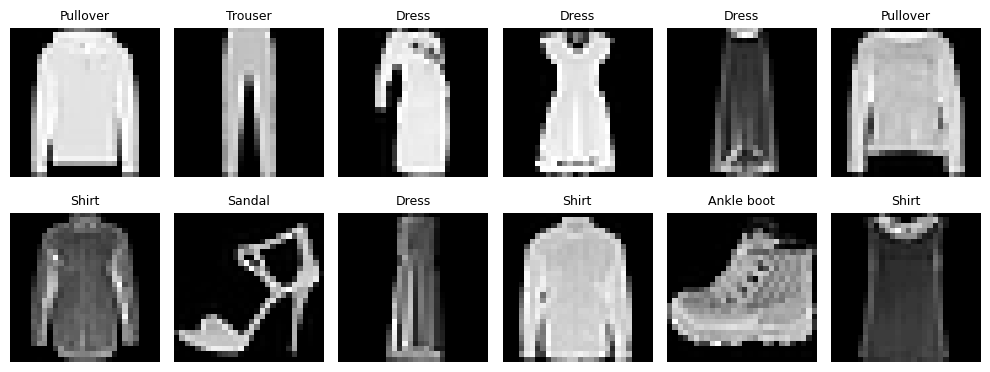

In [18]:
fig, axes = plt.subplots(2, 6, figsize=(10, 4))
for ax in axes.ravel():
    idx = np.random.randint(0, len(train_ds))
    sample = train_ds[idx]
    x, y = sample["image"], sample["label"]

    # unnormalize for display (approx)
    x_vis = (x * 0.5) + 0.5
    # try c_vis = x
    ax.imshow(x_vis.squeeze(0), cmap="gray") #squeeze cuz we have 1 channels
    ax.set_title(class_names[y], fontsize=9)
    ax.axis("off")
plt.tight_layout()
plt.show()


### 1.5 DataLoaders
A DataLoader wraps the dataset and creates batches of data handling batching, shuffling, parallel loading, and more

**Why?** → Neural networks train efficiently on batches, not one image at a time.

In [19]:
batch_size = 128 # design choice: you could change this to 16, 32, 64...

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)


In [20]:
batch = next(iter(train_loader))
xb = batch["image"]
yb = batch["label"]
print("Train loader batch sample X shape (input):", tuple(xb.shape), "\Train loader batch sample y shape (target):", tuple(yb.shape))


<>:4: SyntaxWarning: invalid escape sequence '\T'
<>:4: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipython-input-2566728616.py:4: SyntaxWarning: invalid escape sequence '\T'
  print("Train loader batch sample X shape (input):", tuple(xb.shape), "\Train loader batch sample y shape (target):", tuple(yb.shape))


Train loader batch sample X shape (input): (128, 1, 28, 28) \Train loader batch sample y shape (target): (128,)


## 2️⃣ **Model Class**
Encapsulates the model architecture cleanly as a subclass of nn.Module that defines:

layers in `__init__`

forward computation in `forward()`



![image.png](https://i.imgur.com/8XKBFBU.jpeg)

In [24]:
class SimpleFashionCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(

            # TRACE THE SHAPE OF THE TENSORS AS IT PASSES THROUGH THE CONV LAYERS TO AVOID SHAPE MISMATCH ERRORS
            # HOW? --> by using the output features formula shown above

            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # [B,32,28,28] padding size is propotional to the kernel size
            nn.ReLU(),
            nn.MaxPool2d(2),                             # [B,32,14,14]

            # TO-DO: Add second Conv2d layer (input: 32, output: 64, kernel: 3, padding: 1)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # [B,64,14,14]
            nn.ReLU(),
            # TO-DO: Add MaxPool2d with kernel_size=2
            nn.MaxPool2d(kernel_size= 2),                            # [B,64,7,7]
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            # TO-DO: Calculate input features (channels × height × width)
            # After 2 MaxPool2d(2): 28 → 14 → 7
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # TO-DO: Pass x through features
        x = self.features(x)
        print(x.shape)
        # TO-DO: Pass result through classifier
        x = self.classifier(x)
        return x


In [26]:
!pip install torch-summary

In [28]:
from torchsummary import summary
summary(SimpleFashionCNN(), (1, 28, 28))

torch.Size([2, 64, 7, 7])
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 7, 7]            --
|    └─Conv2d: 2-1                       [-1, 32, 28, 28]          320
|    └─ReLU: 2-2                         [-1, 32, 28, 28]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 14, 14]          --
|    └─Conv2d: 2-4                       [-1, 64, 14, 14]          18,496
|    └─ReLU: 2-5                         [-1, 64, 14, 14]          --
|    └─MaxPool2d: 2-6                    [-1, 64, 7, 7]            --
├─Sequential: 1-2                        [-1, 10]                  --
|    └─Flatten: 2-7                      [-1, 3136]                --
|    └─Linear: 2-8                       [-1, 128]                 401,536
|    └─ReLU: 2-9                         [-1, 128]                 --
|    └─Dropout: 2-10                     [-1, 128]                 --
|    └─Linear: 2-11                      [-1, 10]

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 7, 7]            --
|    └─Conv2d: 2-1                       [-1, 32, 28, 28]          320
|    └─ReLU: 2-2                         [-1, 32, 28, 28]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 14, 14]          --
|    └─Conv2d: 2-4                       [-1, 64, 14, 14]          18,496
|    └─ReLU: 2-5                         [-1, 64, 14, 14]          --
|    └─MaxPool2d: 2-6                    [-1, 64, 7, 7]            --
├─Sequential: 1-2                        [-1, 10]                  --
|    └─Flatten: 2-7                      [-1, 3136]                --
|    └─Linear: 2-8                       [-1, 128]                 401,536
|    └─ReLU: 2-9                         [-1, 128]                 --
|    └─Dropout: 2-10                     [-1, 128]                 --
|    └─Linear: 2-11                      [-1, 10]                  1,290
To

In [25]:
model = SimpleFashionCNN().to(device)

model # let's have a look at our model architecture

SimpleFashionCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

## 3️⃣ **Training & Evaluation**
Code that repeatedly:

1.   passes inputs through the model (forward pass)
2.   computes loss
3.   computes gradients (backward pass)
4.   updates weights (optimizer step)
5.   evaluates on validation/test without updating weights

**Training loop** is how the model learns, while the **validation loop** tells you how it performs on unseen data.

### 3.1 Training function

In [31]:
def accuracy_from_logits(logits, labels):
    # TO-DO: Get predicted class indices
    # HINT: Use torch.argmax with dim=1
    preds = torch.argmax(logits, dim= 1)
    # TO-DO: Calculate and return accuracy
    # HINT: Compare preds with labels, convert to float, mean, then .item()
    return (preds == labels).float().mean().item()

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_acc = 0.0, 0.0

    for batch in tqdm(loader):
        images, labels = batch['image'], batch['label']
        images, labels = images.to(device), labels.to(device)

        # TO-DO: Zero the gradients
        optimizer.zero_grad()

        logits = model(images)
        loss = criterion(logits, labels)

        # TO-DO: Backward pass
        loss.backward()

        # TO-DO: Update parameters
        optimizer.step()

        total_loss += loss.item()
        total_acc += accuracy_from_logits(logits.detach(), labels)

    return total_loss / len(loader), total_acc / len(loader)


### 3.2 Validation function

In [32]:
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_acc = 0.0, 0.0

    with torch.no_grad():
        for batch in tqdm(loader):
            images, labels = batch['image'], batch['label']
            images, labels = images.to(device), labels.to(device)

            # TO-DO: Get model predictions
            logits = model(images)

            # TO-DO: Calculate loss
            # HINT: Use the criterion function
            loss = criterion(logits, labels)

            total_loss += loss.item()
            total_acc += accuracy_from_logits(logits, labels)

    return total_loss / len(loader), total_acc / len(loader)


### 3.3 Setting hyperparameters + training the model

In [33]:
# Training setup
# TO-DO: Define loss criterion
# HINT: What loss function works for multi-class classification?
criterion = nn.CrossEntropyLoss()

# TO-DO: Set learning rate
learning_rate = 0.001

# TO-DO: Define optimizer
# HINT: Pass model.parameters() and learning_rate
optimizer = torch.optim.AdamW(model.parameters(), learning_rate)

# TO-DO: Set number of epochs
num_epochs = 10  # How many times to iterate through the dataset?

# Initialize history tracking
history = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

# Training loop
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    test_loss, test_acc = evaluate(model, test_loader, criterion)

    # Store history
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)

    history["test_loss"].append(test_loss)
    history["test_acc"].append(test_acc)

    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 64, 7, 7])


  1%|▏         | 7/469 [00:00<00:36, 12.71it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  3%|▎         | 13/469 [00:00<00:22, 19.88it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  4%|▍         | 19/469 [00:01<00:18, 23.78it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  5%|▌         | 25/469 [00:01<00:17, 25.02it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  7%|▋         | 31/469 [00:01<00:16, 26.32it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  8%|▊         | 37/469 [00:01<00:15, 27.65it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  9%|▉         | 43/469 [00:02<00:14, 28.53it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 10%|█         | 49/469 [00:02<00:14, 29.01it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 12%|█▏        | 55/469 [00:02<00:14, 29.14it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 13%|█▎        | 61/469 [00:02<00:14, 28.76it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 14%|█▍        | 67/469 [00:02<00:13, 29.02it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 16%|█▌        | 73/469 [00:03<00:13, 29.19it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 17%|█▋        | 79/469 [00:03<00:13, 29.15it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 18%|█▊        | 85/469 [00:03<00:13, 29.15it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 19%|█▉        | 91/469 [00:03<00:13, 28.71it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 21%|██        | 97/469 [00:03<00:12, 28.95it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 21%|██▏       | 100/469 [00:03<00:12, 29.06it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 23%|██▎       | 110/469 [00:04<00:12, 29.38it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 25%|██▍       | 116/469 [00:04<00:12, 29.07it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 26%|██▌       | 122/469 [00:04<00:12, 28.80it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 27%|██▋       | 128/469 [00:04<00:11, 28.90it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 28%|██▊       | 131/469 [00:05<00:11, 28.80it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 29%|██▉       | 137/469 [00:05<00:12, 26.78it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 30%|███       | 143/469 [00:05<00:11, 27.49it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 32%|███▏      | 149/469 [00:05<00:11, 28.20it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 33%|███▎      | 155/469 [00:05<00:10, 28.82it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 34%|███▍      | 161/469 [00:06<00:10, 29.30it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 36%|███▌      | 167/469 [00:06<00:10, 29.39it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 37%|███▋      | 173/469 [00:06<00:10, 29.06it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 38%|███▊      | 179/469 [00:06<00:09, 29.16it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 39%|███▉      | 185/469 [00:06<00:09, 29.06it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 41%|████      | 191/469 [00:07<00:09, 29.22it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 42%|████▏     | 197/469 [00:07<00:09, 29.18it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 43%|████▎     | 203/469 [00:07<00:09, 29.07it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 45%|████▍     | 209/469 [00:07<00:08, 29.34it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 46%|████▌     | 215/469 [00:07<00:08, 29.32it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 47%|████▋     | 221/469 [00:08<00:08, 29.55it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 48%|████▊     | 227/469 [00:08<00:08, 29.21it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 50%|████▉     | 233/469 [00:08<00:08, 28.80it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 51%|█████     | 239/469 [00:08<00:07, 28.76it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 52%|█████▏    | 245/469 [00:09<00:07, 29.00it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 54%|█████▎    | 251/469 [00:09<00:07, 29.25it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 55%|█████▍    | 257/469 [00:09<00:07, 28.86it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 56%|█████▌    | 263/469 [00:09<00:07, 28.99it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 57%|█████▋    | 269/469 [00:09<00:06, 29.24it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 59%|█████▊    | 275/469 [00:10<00:06, 29.46it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 60%|█████▉    | 281/469 [00:10<00:06, 29.47it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 61%|██████    | 287/469 [00:10<00:06, 28.56it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 62%|██████▏   | 293/469 [00:10<00:06, 27.98it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 64%|██████▍   | 299/469 [00:10<00:05, 28.68it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 65%|██████▌   | 305/469 [00:11<00:05, 29.01it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 66%|██████▋   | 311/469 [00:11<00:05, 29.11it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 68%|██████▊   | 317/469 [00:11<00:05, 28.08it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 69%|██████▉   | 323/469 [00:11<00:05, 27.67it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 70%|███████   | 329/469 [00:11<00:04, 28.42it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 71%|███████▏  | 335/469 [00:12<00:04, 28.61it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 73%|███████▎  | 341/469 [00:12<00:04, 28.88it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 74%|███████▍  | 347/469 [00:12<00:04, 28.27it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 75%|███████▌  | 353/469 [00:12<00:04, 28.20it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 77%|███████▋  | 359/469 [00:12<00:03, 28.55it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 78%|███████▊  | 365/469 [00:13<00:03, 28.94it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 79%|███████▉  | 371/469 [00:13<00:03, 29.22it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 80%|████████  | 377/469 [00:13<00:03, 28.74it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 82%|████████▏ | 383/469 [00:13<00:03, 28.60it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 83%|████████▎ | 389/469 [00:14<00:02, 28.49it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 84%|████████▍ | 395/469 [00:14<00:02, 28.85it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 86%|████████▌ | 401/469 [00:14<00:02, 28.95it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 87%|████████▋ | 407/469 [00:14<00:02, 28.69it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 88%|████████▊ | 413/469 [00:14<00:01, 28.22it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 89%|████████▉ | 419/469 [00:15<00:01, 28.65it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 91%|█████████ | 425/469 [00:15<00:01, 28.79it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 92%|█████████▏| 431/469 [00:15<00:01, 28.34it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 93%|█████████▎| 437/469 [00:15<00:01, 28.72it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 94%|█████████▍| 443/469 [00:15<00:00, 28.71it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 96%|█████████▌| 449/469 [00:16<00:00, 29.02it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 97%|█████████▋| 455/469 [00:16<00:00, 28.68it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 98%|█████████▊| 461/469 [00:16<00:00, 28.57it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


100%|██████████| 469/469 [00:16<00:00, 27.86it/s]


torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([96, 64, 7, 7])


 10%|█         | 8/79 [00:00<00:01, 37.38it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 20%|██        | 16/79 [00:00<00:01, 36.99it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 30%|███       | 24/79 [00:00<00:01, 37.00it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 41%|████      | 32/79 [00:00<00:01, 37.30it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 51%|█████     | 40/79 [00:01<00:01, 37.41it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 61%|██████    | 48/79 [00:01<00:00, 37.48it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 71%|███████   | 56/79 [00:01<00:00, 37.03it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 81%|████████  | 64/79 [00:01<00:00, 36.94it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 91%|█████████ | 72/79 [00:01<00:00, 37.12it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


100%|██████████| 79/79 [00:02<00:00, 37.03it/s]


torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([16, 64, 7, 7])
Epoch 1/10 - Train Loss: 0.5759, Train Acc: 0.7933, Test Loss: 0.3670, Test Acc: 0.8658


  1%|▏         | 6/469 [00:00<00:16, 28.31it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  3%|▎         | 12/469 [00:00<00:16, 27.96it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  4%|▍         | 18/469 [00:00<00:16, 28.15it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  5%|▌         | 24/469 [00:00<00:15, 28.76it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  6%|▋         | 30/469 [00:01<00:15, 28.87it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  8%|▊         | 36/469 [00:01<00:15, 28.51it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  9%|▉         | 42/469 [00:01<00:15, 28.12it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 10%|█         | 48/469 [00:01<00:14, 28.37it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 12%|█▏        | 54/469 [00:01<00:14, 28.61it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 13%|█▎        | 60/469 [00:02<00:14, 28.25it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 14%|█▍        | 66/469 [00:02<00:14, 28.23it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 15%|█▌        | 72/469 [00:02<00:13, 28.42it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 17%|█▋        | 78/469 [00:02<00:13, 27.97it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 18%|█▊        | 84/469 [00:02<00:13, 27.84it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 19%|█▉        | 90/469 [00:03<00:13, 28.15it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 20%|██        | 96/469 [00:03<00:13, 28.24it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 22%|██▏       | 102/469 [00:03<00:12, 28.55it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 23%|██▎       | 108/469 [00:03<00:12, 28.80it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 24%|██▍       | 114/469 [00:04<00:12, 27.98it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 26%|██▌       | 120/469 [00:04<00:12, 27.87it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 27%|██▋       | 126/469 [00:04<00:12, 28.28it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 28%|██▊       | 132/469 [00:04<00:11, 28.23it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 29%|██▉       | 138/469 [00:04<00:11, 28.05it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 31%|███       | 144/469 [00:05<00:11, 27.74it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 32%|███▏      | 150/469 [00:05<00:11, 27.69it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 33%|███▎      | 156/469 [00:05<00:11, 27.84it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 35%|███▍      | 162/469 [00:05<00:10, 28.48it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 36%|███▌      | 168/469 [00:05<00:10, 28.73it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 37%|███▋      | 174/469 [00:06<00:10, 28.97it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 38%|███▊      | 180/469 [00:06<00:10, 28.86it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 40%|███▉      | 186/469 [00:06<00:09, 28.78it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 41%|████      | 192/469 [00:06<00:09, 29.10it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 42%|████▏     | 198/469 [00:06<00:09, 29.26it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 43%|████▎     | 204/469 [00:07<00:09, 29.24it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 45%|████▍     | 210/469 [00:07<00:08, 29.22it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 46%|████▌     | 216/469 [00:07<00:08, 29.23it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 47%|████▋     | 222/469 [00:07<00:08, 29.19it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 49%|████▊     | 228/469 [00:08<00:08, 29.29it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 50%|████▉     | 234/469 [00:08<00:08, 29.16it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 51%|█████     | 240/469 [00:08<00:07, 29.16it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 52%|█████▏    | 246/469 [00:08<00:07, 29.40it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 54%|█████▎    | 252/469 [00:08<00:07, 29.31it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 55%|█████▌    | 258/469 [00:09<00:07, 29.30it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 56%|█████▋    | 264/469 [00:09<00:07, 28.77it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 58%|█████▊    | 270/469 [00:09<00:06, 28.86it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 59%|█████▉    | 276/469 [00:09<00:06, 28.86it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 60%|██████    | 282/469 [00:09<00:06, 28.96it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 61%|██████▏   | 288/469 [00:10<00:06, 28.97it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 63%|██████▎   | 294/469 [00:10<00:06, 28.77it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 64%|██████▍   | 300/469 [00:10<00:05, 28.46it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 65%|██████▌   | 306/469 [00:10<00:05, 28.72it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 67%|██████▋   | 312/469 [00:10<00:05, 28.94it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 68%|██████▊   | 318/469 [00:11<00:05, 29.09it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 69%|██████▉   | 324/469 [00:11<00:04, 29.09it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 70%|███████   | 330/469 [00:11<00:04, 28.96it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 72%|███████▏  | 336/469 [00:11<00:04, 28.53it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 73%|███████▎  | 342/469 [00:11<00:04, 28.97it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 74%|███████▍  | 348/469 [00:12<00:04, 28.80it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 75%|███████▌  | 354/469 [00:12<00:04, 28.70it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 77%|███████▋  | 360/469 [00:12<00:03, 29.15it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 78%|███████▊  | 366/469 [00:12<00:03, 29.07it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 79%|███████▉  | 372/469 [00:12<00:03, 29.05it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 81%|████████  | 378/469 [00:13<00:03, 29.27it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 82%|████████▏ | 384/469 [00:13<00:02, 29.11it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 83%|████████▎ | 390/469 [00:13<00:02, 29.21it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 84%|████████▍ | 396/469 [00:13<00:02, 29.01it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 86%|████████▌ | 402/469 [00:14<00:02, 29.10it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 87%|████████▋ | 408/469 [00:14<00:02, 29.25it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 88%|████████▊ | 414/469 [00:14<00:01, 29.13it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 90%|████████▉ | 420/469 [00:14<00:01, 28.72it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 90%|█████████ | 423/469 [00:14<00:01, 28.90it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 92%|█████████▏| 433/469 [00:15<00:01, 29.26it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 94%|█████████▎| 439/469 [00:15<00:01, 29.23it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 95%|█████████▍| 445/469 [00:15<00:00, 28.13it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 96%|█████████▌| 451/469 [00:15<00:00, 28.39it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 97%|█████████▋| 457/469 [00:15<00:00, 28.74it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 99%|█████████▊| 463/469 [00:16<00:00, 29.25it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


100%|██████████| 469/469 [00:16<00:00, 28.72it/s]


torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([96, 64, 7, 7])


  0%|          | 0/79 [00:00<?, ?it/s]

torch.Size([128, 64, 7, 7])


 10%|█         | 8/79 [00:00<00:01, 35.52it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 20%|██        | 16/79 [00:00<00:01, 35.25it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 30%|███       | 24/79 [00:00<00:01, 36.21it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 41%|████      | 32/79 [00:00<00:01, 36.62it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 51%|█████     | 40/79 [00:01<00:01, 36.61it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 61%|██████    | 48/79 [00:01<00:00, 36.69it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 71%|███████   | 56/79 [00:01<00:00, 36.58it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 81%|████████  | 64/79 [00:01<00:00, 36.92it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 91%|█████████ | 72/79 [00:01<00:00, 36.89it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


100%|██████████| 79/79 [00:02<00:00, 36.74it/s]


torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([16, 64, 7, 7])
Epoch 2/10 - Train Loss: 0.3644, Train Acc: 0.8685, Test Loss: 0.3281, Test Acc: 0.8770


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  1%|▏         | 6/469 [00:00<00:16, 27.80it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  3%|▎         | 12/469 [00:00<00:16, 28.19it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  4%|▍         | 18/469 [00:00<00:15, 28.40it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  5%|▌         | 24/469 [00:00<00:15, 28.62it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  6%|▋         | 30/469 [00:01<00:15, 28.12it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  8%|▊         | 36/469 [00:01<00:15, 28.20it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  9%|▉         | 42/469 [00:01<00:15, 28.31it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 10%|█         | 48/469 [00:01<00:14, 28.61it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 12%|█▏        | 54/469 [00:01<00:14, 28.70it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 13%|█▎        | 60/469 [00:02<00:14, 28.59it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 14%|█▍        | 66/469 [00:02<00:14, 28.55it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 15%|█▌        | 72/469 [00:02<00:13, 28.61it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 17%|█▋        | 78/469 [00:02<00:13, 28.81it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 18%|█▊        | 84/469 [00:02<00:13, 28.77it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 19%|█▉        | 90/469 [00:03<00:13, 28.71it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 20%|██        | 96/469 [00:03<00:12, 28.72it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 22%|██▏       | 102/469 [00:03<00:12, 28.71it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 23%|██▎       | 108/469 [00:03<00:12, 28.84it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 24%|██▍       | 114/469 [00:04<00:12, 28.47it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 26%|██▌       | 120/469 [00:04<00:12, 28.53it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 27%|██▋       | 126/469 [00:04<00:11, 28.62it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 28%|██▊       | 132/469 [00:04<00:11, 28.80it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 29%|██▉       | 138/469 [00:04<00:11, 28.87it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 31%|███       | 144/469 [00:05<00:11, 28.94it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 32%|███▏      | 150/469 [00:05<00:11, 28.75it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 33%|███▎      | 156/469 [00:05<00:10, 28.69it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 35%|███▍      | 162/469 [00:05<00:10, 28.61it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 36%|███▌      | 168/469 [00:05<00:10, 28.67it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 37%|███▋      | 174/469 [00:06<00:10, 27.97it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 38%|███▊      | 180/469 [00:06<00:10, 28.31it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 40%|███▉      | 186/469 [00:06<00:10, 28.27it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 41%|████      | 192/469 [00:06<00:09, 28.40it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 42%|████▏     | 198/469 [00:06<00:09, 28.72it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 43%|████▎     | 204/469 [00:07<00:09, 28.48it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 45%|████▍     | 210/469 [00:07<00:09, 28.48it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 46%|████▌     | 216/469 [00:07<00:08, 28.76it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 47%|████▋     | 222/469 [00:07<00:08, 28.81it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 49%|████▊     | 228/469 [00:08<00:08, 28.69it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 50%|████▉     | 234/469 [00:08<00:08, 28.74it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 51%|█████     | 240/469 [00:08<00:08, 28.40it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 52%|█████▏    | 246/469 [00:08<00:07, 28.38it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 54%|█████▎    | 252/469 [00:08<00:07, 28.31it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 55%|█████▌    | 258/469 [00:09<00:07, 27.95it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 56%|█████▋    | 264/469 [00:09<00:07, 27.88it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 58%|█████▊    | 270/469 [00:09<00:07, 26.91it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 58%|█████▊    | 273/469 [00:09<00:07, 26.57it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 59%|█████▉    | 276/469 [00:09<00:07, 25.75it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 59%|█████▉    | 279/469 [00:09<00:07, 26.09it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 60%|██████    | 282/469 [00:09<00:06, 26.83it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 61%|██████    | 285/469 [00:10<00:06, 27.18it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 61%|██████▏   | 288/469 [00:10<00:06, 27.57it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 62%|██████▏   | 291/469 [00:10<00:06, 27.87it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 63%|██████▎   | 294/469 [00:10<00:06, 28.11it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 63%|██████▎   | 297/469 [00:10<00:06, 28.31it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 64%|██████▍   | 300/469 [00:10<00:05, 28.48it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 65%|██████▍   | 303/469 [00:10<00:05, 28.62it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 65%|██████▌   | 306/469 [00:10<00:05, 28.70it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 66%|██████▌   | 309/469 [00:10<00:05, 28.71it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 67%|██████▋   | 312/469 [00:11<00:05, 28.61it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 67%|██████▋   | 315/469 [00:11<00:05, 28.52it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 68%|██████▊   | 318/469 [00:11<00:05, 28.40it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 68%|██████▊   | 321/469 [00:11<00:05, 28.32it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 69%|██████▉   | 324/469 [00:11<00:05, 28.44it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 70%|██████▉   | 327/469 [00:11<00:04, 28.50it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 70%|███████   | 330/469 [00:11<00:04, 28.65it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 71%|███████   | 333/469 [00:11<00:04, 28.68it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 72%|███████▏  | 336/469 [00:11<00:04, 28.75it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 72%|███████▏  | 339/469 [00:11<00:04, 28.75it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 73%|███████▎  | 342/469 [00:12<00:04, 28.78it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 74%|███████▎  | 345/469 [00:12<00:04, 28.47it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 74%|███████▍  | 348/469 [00:12<00:04, 28.40it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 75%|███████▍  | 351/469 [00:12<00:04, 28.32it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 75%|███████▌  | 354/469 [00:12<00:04, 28.33it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 76%|███████▌  | 357/469 [00:12<00:03, 28.20it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 77%|███████▋  | 360/469 [00:12<00:03, 28.40it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 77%|███████▋  | 363/469 [00:12<00:03, 28.49it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 78%|███████▊  | 366/469 [00:12<00:03, 28.62it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 79%|███████▊  | 369/469 [00:13<00:03, 28.54it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 79%|███████▉  | 372/469 [00:13<00:03, 28.63it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 80%|███████▉  | 375/469 [00:13<00:03, 28.67it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 81%|████████  | 378/469 [00:13<00:03, 28.68it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 81%|████████  | 381/469 [00:13<00:03, 28.65it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 82%|████████▏ | 384/469 [00:13<00:02, 28.69it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 83%|████████▎ | 387/469 [00:13<00:02, 28.65it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 83%|████████▎ | 390/469 [00:13<00:02, 28.71it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 84%|████████▍ | 393/469 [00:13<00:02, 28.70it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 84%|████████▍ | 396/469 [00:13<00:02, 28.84it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 85%|████████▌ | 399/469 [00:14<00:02, 28.78it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 86%|████████▌ | 402/469 [00:14<00:02, 28.47it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 86%|████████▋ | 405/469 [00:14<00:02, 28.37it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 87%|████████▋ | 408/469 [00:14<00:02, 28.51it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 88%|████████▊ | 411/469 [00:14<00:02, 28.74it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 88%|████████▊ | 414/469 [00:14<00:01, 28.86it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 89%|████████▉ | 417/469 [00:14<00:01, 28.84it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 90%|████████▉ | 420/469 [00:14<00:01, 29.06it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 90%|█████████ | 423/469 [00:14<00:01, 28.83it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 91%|█████████ | 426/469 [00:15<00:01, 28.92it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 91%|█████████▏| 429/469 [00:15<00:01, 28.75it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 92%|█████████▏| 432/469 [00:15<00:01, 28.79it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 93%|█████████▎| 435/469 [00:15<00:01, 28.59it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 93%|█████████▎| 438/469 [00:15<00:01, 28.67it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 94%|█████████▍| 441/469 [00:15<00:00, 28.72it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 95%|█████████▍| 444/469 [00:15<00:00, 28.82it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 95%|█████████▌| 447/469 [00:15<00:00, 28.83it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 96%|█████████▌| 450/469 [00:15<00:00, 28.92it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 97%|█████████▋| 453/469 [00:15<00:00, 28.76it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 97%|█████████▋| 456/469 [00:16<00:00, 28.88it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 98%|█████████▊| 459/469 [00:16<00:00, 28.61it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 99%|█████████▊| 462/469 [00:16<00:00, 28.78it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 99%|█████████▉| 465/469 [00:16<00:00, 28.78it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


100%|██████████| 469/469 [00:16<00:00, 28.42it/s]


torch.Size([128, 64, 7, 7])
torch.Size([96, 64, 7, 7])


  0%|          | 0/79 [00:00<?, ?it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  5%|▌         | 4/79 [00:00<00:02, 36.86it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 10%|█         | 8/79 [00:00<00:01, 37.25it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 15%|█▌        | 12/79 [00:00<00:01, 37.03it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 20%|██        | 16/79 [00:00<00:01, 36.90it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 25%|██▌       | 20/79 [00:00<00:01, 36.84it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 30%|███       | 24/79 [00:00<00:01, 36.97it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 35%|███▌      | 28/79 [00:00<00:01, 37.13it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 41%|████      | 32/79 [00:00<00:01, 37.26it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 46%|████▌     | 36/79 [00:00<00:01, 37.37it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 51%|█████     | 40/79 [00:01<00:01, 37.55it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 56%|█████▌    | 44/79 [00:01<00:00, 37.47it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 61%|██████    | 48/79 [00:01<00:00, 37.33it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 66%|██████▌   | 52/79 [00:01<00:00, 36.78it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 71%|███████   | 56/79 [00:01<00:00, 36.59it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 76%|███████▌  | 60/79 [00:01<00:00, 36.21it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 81%|████████  | 64/79 [00:01<00:00, 36.56it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 86%|████████▌ | 68/79 [00:01<00:00, 36.68it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 91%|█████████ | 72/79 [00:01<00:00, 36.67it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


100%|██████████| 79/79 [00:02<00:00, 37.36it/s]


torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([16, 64, 7, 7])
Epoch 3/10 - Train Loss: 0.3131, Train Acc: 0.8847, Test Loss: 0.2997, Test Acc: 0.8874


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 64, 7, 7])


  1%|          | 3/469 [00:00<00:16, 28.73it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  1%|▏         | 6/469 [00:00<00:15, 29.04it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  2%|▏         | 9/469 [00:00<00:16, 28.62it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  3%|▎         | 12/469 [00:00<00:15, 28.65it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  3%|▎         | 15/469 [00:00<00:16, 28.27it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  4%|▍         | 18/469 [00:00<00:15, 28.56it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  4%|▍         | 21/469 [00:00<00:15, 28.54it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  5%|▌         | 24/469 [00:00<00:15, 28.44it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  6%|▌         | 27/469 [00:00<00:15, 28.61it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  6%|▋         | 30/469 [00:01<00:15, 28.91it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  7%|▋         | 33/469 [00:01<00:15, 28.74it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  8%|▊         | 36/469 [00:01<00:15, 28.31it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  8%|▊         | 39/469 [00:01<00:15, 27.51it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  9%|▉         | 42/469 [00:01<00:15, 27.53it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 10%|▉         | 45/469 [00:01<00:15, 27.69it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 10%|█         | 48/469 [00:01<00:15, 27.97it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 11%|█         | 51/469 [00:01<00:14, 27.90it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 12%|█▏        | 54/469 [00:01<00:15, 27.64it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 12%|█▏        | 57/469 [00:02<00:14, 27.57it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 13%|█▎        | 60/469 [00:02<00:14, 27.40it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 13%|█▎        | 63/469 [00:02<00:14, 27.14it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 14%|█▍        | 66/469 [00:02<00:14, 27.12it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 15%|█▍        | 69/469 [00:02<00:14, 26.86it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 15%|█▌        | 72/469 [00:02<00:14, 26.91it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 16%|█▌        | 75/469 [00:02<00:14, 27.18it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 17%|█▋        | 78/469 [00:02<00:14, 27.58it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 17%|█▋        | 81/469 [00:02<00:14, 27.60it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 18%|█▊        | 84/469 [00:03<00:13, 27.63it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 19%|█▊        | 87/469 [00:03<00:13, 27.72it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 19%|█▉        | 90/469 [00:03<00:13, 27.87it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 20%|█▉        | 93/469 [00:03<00:13, 28.03it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 20%|██        | 96/469 [00:03<00:13, 28.26it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 21%|██        | 99/469 [00:03<00:13, 28.34it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 22%|██▏       | 102/469 [00:03<00:12, 28.50it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 22%|██▏       | 105/469 [00:03<00:12, 28.56it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 23%|██▎       | 108/469 [00:03<00:12, 28.39it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 24%|██▎       | 111/469 [00:03<00:12, 28.18it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 24%|██▍       | 114/469 [00:04<00:12, 28.25it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 25%|██▍       | 117/469 [00:04<00:12, 28.27it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 26%|██▌       | 120/469 [00:04<00:12, 28.40it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 26%|██▌       | 123/469 [00:04<00:12, 28.46it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 27%|██▋       | 126/469 [00:04<00:12, 28.58it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 28%|██▊       | 129/469 [00:04<00:11, 28.57it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 28%|██▊       | 132/469 [00:04<00:11, 28.63it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 29%|██▉       | 135/469 [00:04<00:11, 28.57it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 29%|██▉       | 138/469 [00:04<00:11, 28.31it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 30%|███       | 141/469 [00:05<00:11, 28.17it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 31%|███       | 144/469 [00:05<00:11, 28.24it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 31%|███▏      | 147/469 [00:05<00:11, 28.21it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 32%|███▏      | 150/469 [00:05<00:11, 28.37it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 33%|███▎      | 153/469 [00:05<00:11, 28.37it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 33%|███▎      | 156/469 [00:05<00:10, 28.52it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 34%|███▍      | 159/469 [00:05<00:10, 28.50it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 35%|███▍      | 162/469 [00:05<00:10, 28.48it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 35%|███▌      | 165/469 [00:05<00:10, 28.40it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 36%|███▌      | 168/469 [00:05<00:10, 28.43it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 36%|███▋      | 171/469 [00:06<00:10, 28.37it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 37%|███▋      | 174/469 [00:06<00:10, 28.62it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 38%|███▊      | 177/469 [00:06<00:10, 28.65it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 38%|███▊      | 180/469 [00:06<00:10, 28.74it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 39%|███▉      | 183/469 [00:06<00:10, 28.49it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 40%|███▉      | 186/469 [00:06<00:09, 28.65it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 40%|████      | 189/469 [00:06<00:09, 28.35it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 41%|████      | 192/469 [00:06<00:09, 28.40it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 42%|████▏     | 195/469 [00:06<00:09, 28.36it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 42%|████▏     | 198/469 [00:07<00:09, 28.53it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 43%|████▎     | 201/469 [00:07<00:09, 28.42it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 43%|████▎     | 204/469 [00:07<00:09, 28.62it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 44%|████▍     | 207/469 [00:07<00:09, 28.55it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 45%|████▍     | 210/469 [00:07<00:09, 28.57it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 45%|████▌     | 213/469 [00:07<00:09, 28.42it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 46%|████▌     | 216/469 [00:07<00:08, 28.36it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 47%|████▋     | 219/469 [00:07<00:08, 27.97it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 47%|████▋     | 222/469 [00:07<00:08, 28.18it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 48%|████▊     | 225/469 [00:07<00:08, 28.26it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 49%|████▊     | 228/469 [00:08<00:08, 28.46it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 49%|████▉     | 231/469 [00:08<00:08, 28.60it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 50%|████▉     | 234/469 [00:08<00:08, 28.67it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 51%|█████     | 237/469 [00:08<00:08, 28.19it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 51%|█████     | 240/469 [00:08<00:08, 28.04it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 52%|█████▏    | 243/469 [00:08<00:08, 28.11it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 52%|█████▏    | 246/469 [00:08<00:07, 28.09it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 53%|█████▎    | 249/469 [00:08<00:07, 27.83it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 54%|█████▎    | 252/469 [00:08<00:07, 28.15it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 54%|█████▍    | 255/469 [00:09<00:07, 28.12it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 55%|█████▌    | 258/469 [00:09<00:07, 28.39it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 56%|█████▌    | 261/469 [00:09<00:07, 28.29it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 56%|█████▋    | 264/469 [00:09<00:07, 28.41it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 57%|█████▋    | 267/469 [00:09<00:07, 28.38it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 58%|█████▊    | 270/469 [00:09<00:07, 28.33it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 58%|█████▊    | 273/469 [00:09<00:06, 28.19it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 59%|█████▉    | 276/469 [00:09<00:06, 28.25it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 59%|█████▉    | 279/469 [00:09<00:06, 27.63it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 60%|██████    | 282/469 [00:10<00:06, 28.05it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 61%|██████    | 285/469 [00:10<00:06, 28.16it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 61%|██████▏   | 288/469 [00:10<00:06, 28.12it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 62%|██████▏   | 291/469 [00:10<00:06, 27.98it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 63%|██████▎   | 294/469 [00:10<00:06, 27.86it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 63%|██████▎   | 297/469 [00:10<00:06, 27.88it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 64%|██████▍   | 300/469 [00:10<00:06, 28.05it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 65%|██████▍   | 303/469 [00:10<00:05, 28.07it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 65%|██████▌   | 306/469 [00:10<00:05, 28.36it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 66%|██████▌   | 309/469 [00:10<00:05, 28.42it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 67%|██████▋   | 312/469 [00:11<00:05, 28.64it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 67%|██████▋   | 315/469 [00:11<00:05, 28.62it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 68%|██████▊   | 318/469 [00:11<00:05, 28.73it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 68%|██████▊   | 321/469 [00:11<00:05, 28.65it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 69%|██████▉   | 324/469 [00:11<00:05, 28.40it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 70%|██████▉   | 327/469 [00:11<00:05, 28.09it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 70%|███████   | 330/469 [00:11<00:04, 28.10it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 71%|███████   | 333/469 [00:11<00:04, 28.15it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 72%|███████▏  | 336/469 [00:11<00:04, 28.38it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 72%|███████▏  | 339/469 [00:12<00:04, 28.42it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 73%|███████▎  | 342/469 [00:12<00:04, 28.43it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 74%|███████▎  | 345/469 [00:12<00:04, 28.36it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 74%|███████▍  | 348/469 [00:12<00:04, 28.52it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 75%|███████▍  | 351/469 [00:12<00:04, 28.50it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 75%|███████▌  | 354/469 [00:12<00:04, 28.46it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 76%|███████▌  | 357/469 [00:12<00:03, 28.20it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 77%|███████▋  | 360/469 [00:12<00:03, 27.63it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 77%|███████▋  | 363/469 [00:12<00:03, 27.70it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 78%|███████▊  | 366/469 [00:12<00:03, 27.74it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 79%|███████▊  | 369/469 [00:13<00:03, 27.78it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 79%|███████▉  | 372/469 [00:13<00:03, 28.11it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 80%|███████▉  | 375/469 [00:13<00:03, 28.16it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 81%|████████  | 378/469 [00:13<00:03, 28.30it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 81%|████████  | 381/469 [00:13<00:03, 28.38it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 82%|████████▏ | 384/469 [00:13<00:03, 28.30it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 83%|████████▎ | 387/469 [00:13<00:02, 27.94it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 83%|████████▎ | 390/469 [00:13<00:02, 28.13it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 84%|████████▍ | 393/469 [00:13<00:02, 27.91it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 84%|████████▍ | 396/469 [00:14<00:02, 27.83it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 85%|████████▌ | 399/469 [00:14<00:02, 27.28it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 86%|████████▌ | 402/469 [00:14<00:02, 27.38it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 86%|████████▋ | 405/469 [00:14<00:02, 27.17it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 87%|████████▋ | 408/469 [00:14<00:02, 27.08it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 88%|████████▊ | 411/469 [00:14<00:02, 27.05it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 88%|████████▊ | 414/469 [00:14<00:02, 27.42it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 89%|████████▉ | 417/469 [00:14<00:01, 27.56it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 90%|████████▉ | 420/469 [00:14<00:01, 27.69it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 90%|█████████ | 423/469 [00:15<00:01, 27.90it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 91%|█████████ | 426/469 [00:15<00:01, 28.28it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 91%|█████████▏| 429/469 [00:15<00:01, 28.40it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 92%|█████████▏| 432/469 [00:15<00:01, 28.40it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 93%|█████████▎| 435/469 [00:15<00:01, 28.47it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 93%|█████████▎| 438/469 [00:15<00:01, 28.49it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 94%|█████████▍| 441/469 [00:15<00:00, 28.46it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 95%|█████████▍| 444/469 [00:15<00:00, 28.73it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 95%|█████████▌| 447/469 [00:15<00:00, 28.81it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 96%|█████████▌| 450/469 [00:15<00:00, 28.88it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 97%|█████████▋| 453/469 [00:16<00:00, 28.92it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 97%|█████████▋| 456/469 [00:16<00:00, 28.96it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 98%|█████████▊| 459/469 [00:16<00:00, 28.81it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 99%|█████████▊| 462/469 [00:16<00:00, 28.56it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 99%|█████████▉| 465/469 [00:16<00:00, 28.60it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


100%|█████████▉| 468/469 [00:16<00:00, 28.82it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


100%|██████████| 469/469 [00:16<00:00, 28.21it/s]


torch.Size([96, 64, 7, 7])


  0%|          | 0/79 [00:00<?, ?it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  5%|▌         | 4/79 [00:00<00:02, 35.83it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 10%|█         | 8/79 [00:00<00:01, 36.20it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 15%|█▌        | 12/79 [00:00<00:01, 36.05it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 20%|██        | 16/79 [00:00<00:01, 36.29it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 25%|██▌       | 20/79 [00:00<00:01, 36.31it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 30%|███       | 24/79 [00:00<00:01, 36.36it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 35%|███▌      | 28/79 [00:00<00:01, 35.96it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 41%|████      | 32/79 [00:00<00:01, 36.19it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 46%|████▌     | 36/79 [00:00<00:01, 36.09it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 51%|█████     | 40/79 [00:01<00:01, 36.54it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 56%|█████▌    | 44/79 [00:01<00:00, 36.32it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 61%|██████    | 48/79 [00:01<00:00, 36.61it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 66%|██████▌   | 52/79 [00:01<00:00, 36.56it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 71%|███████   | 56/79 [00:01<00:00, 36.66it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 76%|███████▌  | 60/79 [00:01<00:00, 36.59it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 81%|████████  | 64/79 [00:01<00:00, 36.88it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 86%|████████▌ | 68/79 [00:01<00:00, 36.75it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 91%|█████████ | 72/79 [00:01<00:00, 36.99it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


100%|██████████| 79/79 [00:02<00:00, 36.91it/s]


torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([16, 64, 7, 7])
Epoch 4/10 - Train Loss: 0.2820, Train Acc: 0.8965, Test Loss: 0.2741, Test Acc: 0.8998


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  1%|          | 3/469 [00:00<00:17, 27.30it/s]

torch.Size([128, 64, 7, 7])


  1%|▏         | 6/469 [00:00<00:16, 28.18it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  2%|▏         | 9/469 [00:00<00:16, 28.36it/s]

torch.Size([128, 64, 7, 7])


  3%|▎         | 12/469 [00:00<00:16, 28.45it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  3%|▎         | 15/469 [00:00<00:16, 28.01it/s]

torch.Size([128, 64, 7, 7])


  4%|▍         | 18/469 [00:00<00:15, 28.29it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  4%|▍         | 21/469 [00:00<00:16, 27.71it/s]

torch.Size([128, 64, 7, 7])


  5%|▌         | 24/469 [00:00<00:15, 28.07it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  6%|▌         | 27/469 [00:00<00:15, 27.85it/s]

torch.Size([128, 64, 7, 7])


  6%|▋         | 30/469 [00:01<00:15, 27.94it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  7%|▋         | 33/469 [00:01<00:15, 27.63it/s]

torch.Size([128, 64, 7, 7])


  8%|▊         | 36/469 [00:01<00:15, 28.09it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  8%|▊         | 39/469 [00:01<00:15, 28.07it/s]

torch.Size([128, 64, 7, 7])


  9%|▉         | 42/469 [00:01<00:14, 28.49it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 10%|▉         | 45/469 [00:01<00:14, 28.28it/s]

torch.Size([128, 64, 7, 7])


 10%|█         | 48/469 [00:01<00:14, 28.61it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 11%|█         | 51/469 [00:01<00:14, 28.45it/s]

torch.Size([128, 64, 7, 7])


 12%|█▏        | 54/469 [00:01<00:14, 28.70it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 12%|█▏        | 57/469 [00:02<00:14, 28.66it/s]

torch.Size([128, 64, 7, 7])


 13%|█▎        | 60/469 [00:02<00:14, 28.83it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 13%|█▎        | 63/469 [00:02<00:14, 28.86it/s]

torch.Size([128, 64, 7, 7])


 14%|█▍        | 66/469 [00:02<00:13, 29.07it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 15%|█▍        | 69/469 [00:02<00:14, 27.94it/s]

torch.Size([128, 64, 7, 7])


 15%|█▌        | 72/469 [00:02<00:14, 27.76it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 16%|█▌        | 75/469 [00:02<00:14, 27.59it/s]

torch.Size([128, 64, 7, 7])


 17%|█▋        | 78/469 [00:02<00:13, 27.98it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 17%|█▋        | 81/469 [00:02<00:13, 28.02it/s]

torch.Size([128, 64, 7, 7])


 18%|█▊        | 84/469 [00:02<00:13, 28.31it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 19%|█▊        | 87/469 [00:03<00:13, 28.32it/s]

torch.Size([128, 64, 7, 7])


 19%|█▉        | 90/469 [00:03<00:13, 28.44it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 20%|█▉        | 93/469 [00:03<00:13, 28.45it/s]

torch.Size([128, 64, 7, 7])


 20%|██        | 96/469 [00:03<00:12, 28.72it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 21%|██        | 99/469 [00:03<00:12, 28.59it/s]

torch.Size([128, 64, 7, 7])


 22%|██▏       | 102/469 [00:03<00:12, 28.68it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 22%|██▏       | 105/469 [00:03<00:12, 28.43it/s]

torch.Size([128, 64, 7, 7])


 23%|██▎       | 108/469 [00:03<00:12, 28.40it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 24%|██▎       | 111/469 [00:03<00:12, 28.00it/s]

torch.Size([128, 64, 7, 7])


 24%|██▍       | 114/469 [00:04<00:12, 28.22it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 25%|██▍       | 117/469 [00:04<00:12, 27.97it/s]

torch.Size([128, 64, 7, 7])


 26%|██▌       | 120/469 [00:04<00:12, 28.06it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 26%|██▌       | 123/469 [00:04<00:12, 27.92it/s]

torch.Size([128, 64, 7, 7])


 27%|██▋       | 126/469 [00:04<00:12, 28.36it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 28%|██▊       | 129/469 [00:04<00:11, 28.49it/s]

torch.Size([128, 64, 7, 7])


 28%|██▊       | 132/469 [00:04<00:11, 28.67it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 29%|██▉       | 135/469 [00:04<00:11, 28.66it/s]

torch.Size([128, 64, 7, 7])


 29%|██▉       | 138/469 [00:04<00:11, 28.79it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 30%|███       | 141/469 [00:04<00:11, 28.42it/s]

torch.Size([128, 64, 7, 7])


 31%|███       | 144/469 [00:05<00:11, 28.59it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 31%|███▏      | 147/469 [00:05<00:11, 28.47it/s]

torch.Size([128, 64, 7, 7])


 32%|███▏      | 150/469 [00:05<00:11, 28.34it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 33%|███▎      | 153/469 [00:05<00:11, 28.18it/s]

torch.Size([128, 64, 7, 7])


 33%|███▎      | 156/469 [00:05<00:11, 28.06it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 34%|███▍      | 159/469 [00:05<00:11, 27.57it/s]

torch.Size([128, 64, 7, 7])


 35%|███▍      | 162/469 [00:05<00:11, 27.69it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 35%|███▌      | 165/469 [00:05<00:11, 27.55it/s]

torch.Size([128, 64, 7, 7])


 36%|███▌      | 168/469 [00:05<00:10, 27.76it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 36%|███▋      | 171/469 [00:06<00:10, 27.51it/s]

torch.Size([128, 64, 7, 7])


 37%|███▋      | 174/469 [00:06<00:10, 27.90it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 38%|███▊      | 177/469 [00:06<00:10, 27.79it/s]

torch.Size([128, 64, 7, 7])


 38%|███▊      | 180/469 [00:06<00:10, 27.89it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 39%|███▉      | 183/469 [00:06<00:10, 27.61it/s]

torch.Size([128, 64, 7, 7])


 40%|███▉      | 186/469 [00:06<00:10, 27.40it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 40%|████      | 189/469 [00:06<00:10, 27.20it/s]

torch.Size([128, 64, 7, 7])


 41%|████      | 192/469 [00:06<00:10, 27.67it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 42%|████▏     | 195/469 [00:06<00:09, 27.92it/s]

torch.Size([128, 64, 7, 7])


 42%|████▏     | 198/469 [00:07<00:09, 28.10it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 43%|████▎     | 201/469 [00:07<00:09, 28.18it/s]

torch.Size([128, 64, 7, 7])


 43%|████▎     | 204/469 [00:07<00:09, 28.56it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 44%|████▍     | 207/469 [00:07<00:09, 28.55it/s]

torch.Size([128, 64, 7, 7])


 45%|████▍     | 210/469 [00:07<00:09, 28.65it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 45%|████▌     | 213/469 [00:07<00:09, 28.13it/s]

torch.Size([128, 64, 7, 7])


 46%|████▌     | 216/469 [00:07<00:09, 28.10it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 47%|████▋     | 219/469 [00:07<00:09, 27.67it/s]

torch.Size([128, 64, 7, 7])


 47%|████▋     | 222/469 [00:07<00:08, 27.85it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 48%|████▊     | 225/469 [00:07<00:08, 27.95it/s]

torch.Size([128, 64, 7, 7])


 49%|████▊     | 228/469 [00:08<00:08, 28.33it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 49%|████▉     | 231/469 [00:08<00:08, 27.95it/s]

torch.Size([128, 64, 7, 7])


 50%|████▉     | 234/469 [00:08<00:08, 28.16it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 51%|█████     | 237/469 [00:08<00:08, 27.84it/s]

torch.Size([128, 64, 7, 7])


 51%|█████     | 240/469 [00:08<00:08, 28.03it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 52%|█████▏    | 243/469 [00:08<00:08, 27.84it/s]

torch.Size([128, 64, 7, 7])


 52%|█████▏    | 246/469 [00:08<00:08, 27.86it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 53%|█████▎    | 249/469 [00:08<00:07, 27.95it/s]

torch.Size([128, 64, 7, 7])


 54%|█████▎    | 252/469 [00:08<00:07, 28.25it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 54%|█████▍    | 255/469 [00:09<00:07, 28.18it/s]

torch.Size([128, 64, 7, 7])


 55%|█████▌    | 258/469 [00:09<00:07, 28.55it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 56%|█████▌    | 261/469 [00:09<00:07, 28.54it/s]

torch.Size([128, 64, 7, 7])


 56%|█████▋    | 264/469 [00:09<00:07, 28.82it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 57%|█████▋    | 267/469 [00:09<00:07, 28.20it/s]

torch.Size([128, 64, 7, 7])


 58%|█████▊    | 270/469 [00:09<00:07, 28.22it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 58%|█████▊    | 273/469 [00:09<00:06, 28.09it/s]

torch.Size([128, 64, 7, 7])


 59%|█████▉    | 276/469 [00:09<00:06, 28.22it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 59%|█████▉    | 279/469 [00:09<00:06, 28.30it/s]

torch.Size([128, 64, 7, 7])


 60%|██████    | 282/469 [00:10<00:06, 28.61it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 61%|██████    | 285/469 [00:10<00:06, 28.47it/s]

torch.Size([128, 64, 7, 7])


 61%|██████▏   | 288/469 [00:10<00:06, 28.60it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 62%|██████▏   | 291/469 [00:10<00:06, 28.16it/s]

torch.Size([128, 64, 7, 7])


 63%|██████▎   | 294/469 [00:10<00:06, 28.43it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 63%|██████▎   | 297/469 [00:10<00:06, 28.28it/s]

torch.Size([128, 64, 7, 7])


 64%|██████▍   | 300/469 [00:10<00:05, 28.38it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 65%|██████▍   | 303/469 [00:10<00:05, 28.33it/s]

torch.Size([128, 64, 7, 7])


 65%|██████▌   | 306/469 [00:10<00:05, 28.25it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 66%|██████▌   | 309/469 [00:10<00:05, 28.28it/s]

torch.Size([128, 64, 7, 7])


 67%|██████▋   | 312/469 [00:11<00:05, 28.24it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 67%|██████▋   | 315/469 [00:11<00:05, 28.18it/s]

torch.Size([128, 64, 7, 7])


 68%|██████▊   | 318/469 [00:11<00:05, 28.46it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 68%|██████▊   | 321/469 [00:11<00:05, 28.04it/s]

torch.Size([128, 64, 7, 7])


 69%|██████▉   | 324/469 [00:11<00:05, 28.26it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 70%|██████▉   | 327/469 [00:11<00:04, 28.47it/s]

torch.Size([128, 64, 7, 7])


 70%|███████   | 330/469 [00:11<00:04, 28.62it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 71%|███████   | 333/469 [00:11<00:04, 28.05it/s]

torch.Size([128, 64, 7, 7])


 72%|███████▏  | 336/469 [00:11<00:04, 28.31it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 72%|███████▏  | 339/469 [00:12<00:04, 28.38it/s]

torch.Size([128, 64, 7, 7])


 73%|███████▎  | 342/469 [00:12<00:04, 28.60it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 74%|███████▎  | 345/469 [00:12<00:04, 28.76it/s]

torch.Size([128, 64, 7, 7])


 74%|███████▍  | 348/469 [00:12<00:04, 28.91it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 75%|███████▍  | 351/469 [00:12<00:04, 28.84it/s]

torch.Size([128, 64, 7, 7])


 75%|███████▌  | 354/469 [00:12<00:04, 28.48it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 76%|███████▌  | 357/469 [00:12<00:03, 28.55it/s]

torch.Size([128, 64, 7, 7])


 77%|███████▋  | 360/469 [00:12<00:03, 28.72it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 77%|███████▋  | 363/469 [00:12<00:03, 28.70it/s]

torch.Size([128, 64, 7, 7])


 78%|███████▊  | 366/469 [00:12<00:03, 28.83it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 79%|███████▊  | 369/469 [00:13<00:03, 28.86it/s]

torch.Size([128, 64, 7, 7])


 79%|███████▉  | 372/469 [00:13<00:03, 28.99it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 80%|███████▉  | 375/469 [00:13<00:03, 28.79it/s]

torch.Size([128, 64, 7, 7])


 81%|████████  | 378/469 [00:13<00:03, 28.98it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 81%|████████  | 381/469 [00:13<00:03, 28.29it/s]

torch.Size([128, 64, 7, 7])


 82%|████████▏ | 384/469 [00:13<00:02, 28.35it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 83%|████████▎ | 387/469 [00:13<00:02, 28.28it/s]

torch.Size([128, 64, 7, 7])


 83%|████████▎ | 390/469 [00:13<00:02, 28.39it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 84%|████████▍ | 393/469 [00:13<00:02, 28.14it/s]

torch.Size([128, 64, 7, 7])


 84%|████████▍ | 396/469 [00:14<00:02, 28.32it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 85%|████████▌ | 399/469 [00:14<00:02, 27.82it/s]

torch.Size([128, 64, 7, 7])


 86%|████████▌ | 402/469 [00:14<00:02, 27.86it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 86%|████████▋ | 405/469 [00:14<00:02, 27.92it/s]

torch.Size([128, 64, 7, 7])


 87%|████████▋ | 408/469 [00:14<00:02, 28.20it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 88%|████████▊ | 411/469 [00:14<00:02, 27.82it/s]

torch.Size([128, 64, 7, 7])


 88%|████████▊ | 414/469 [00:14<00:01, 28.11it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 89%|████████▉ | 417/469 [00:14<00:01, 27.94it/s]

torch.Size([128, 64, 7, 7])


 90%|████████▉ | 420/469 [00:14<00:01, 28.29it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 90%|█████████ | 423/469 [00:14<00:01, 28.16it/s]

torch.Size([128, 64, 7, 7])


 91%|█████████ | 426/469 [00:15<00:01, 28.42it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 91%|█████████▏| 429/469 [00:15<00:01, 28.33it/s]

torch.Size([128, 64, 7, 7])


 92%|█████████▏| 432/469 [00:15<00:01, 28.43it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 93%|█████████▎| 435/469 [00:15<00:01, 28.44it/s]

torch.Size([128, 64, 7, 7])


 93%|█████████▎| 438/469 [00:15<00:01, 28.48it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 94%|█████████▍| 441/469 [00:15<00:01, 27.95it/s]

torch.Size([128, 64, 7, 7])


 95%|█████████▍| 444/469 [00:15<00:00, 28.22it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 95%|█████████▌| 447/469 [00:15<00:00, 27.56it/s]

torch.Size([128, 64, 7, 7])


 96%|█████████▌| 450/469 [00:15<00:00, 27.76it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 97%|█████████▋| 453/469 [00:16<00:00, 27.55it/s]

torch.Size([128, 64, 7, 7])


 97%|█████████▋| 456/469 [00:16<00:00, 27.98it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 98%|█████████▊| 459/469 [00:16<00:00, 28.01it/s]

torch.Size([128, 64, 7, 7])


 99%|█████████▊| 462/469 [00:16<00:00, 28.41it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 99%|█████████▉| 465/469 [00:16<00:00, 28.38it/s]

torch.Size([128, 64, 7, 7])


100%|█████████▉| 468/469 [00:16<00:00, 28.65it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


100%|██████████| 469/469 [00:16<00:00, 28.24it/s]


torch.Size([96, 64, 7, 7])


  0%|          | 0/79 [00:00<?, ?it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  5%|▌         | 4/79 [00:00<00:02, 34.85it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 10%|█         | 8/79 [00:00<00:02, 35.36it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 15%|█▌        | 12/79 [00:00<00:01, 34.35it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 20%|██        | 16/79 [00:00<00:01, 35.37it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 25%|██▌       | 20/79 [00:00<00:01, 35.36it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 30%|███       | 24/79 [00:00<00:01, 35.79it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 35%|███▌      | 28/79 [00:00<00:01, 35.87it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 41%|████      | 32/79 [00:00<00:01, 36.09it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 46%|████▌     | 36/79 [00:01<00:01, 35.93it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 51%|█████     | 40/79 [00:01<00:01, 34.60it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 56%|█████▌    | 44/79 [00:01<00:01, 34.62it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 61%|██████    | 48/79 [00:01<00:00, 34.26it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 66%|██████▌   | 52/79 [00:01<00:00, 34.33it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 71%|███████   | 56/79 [00:01<00:00, 34.59it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 76%|███████▌  | 60/79 [00:01<00:00, 34.70it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 81%|████████  | 64/79 [00:01<00:00, 35.25it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 86%|████████▌ | 68/79 [00:01<00:00, 35.62it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 91%|█████████ | 72/79 [00:02<00:00, 35.85it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 96%|█████████▌| 76/79 [00:02<00:00, 35.83it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


100%|██████████| 79/79 [00:02<00:00, 35.66it/s]


torch.Size([128, 64, 7, 7])
torch.Size([16, 64, 7, 7])
Epoch 5/10 - Train Loss: 0.2619, Train Acc: 0.9047, Test Loss: 0.2587, Test Acc: 0.9056


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 64, 7, 7])


  1%|          | 3/469 [00:00<00:16, 27.48it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  1%|▏         | 6/469 [00:00<00:16, 28.03it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  2%|▏         | 9/469 [00:00<00:16, 28.26it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  3%|▎         | 12/469 [00:00<00:16, 28.46it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  3%|▎         | 15/469 [00:00<00:15, 28.44it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  4%|▍         | 18/469 [00:00<00:15, 28.52it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  4%|▍         | 21/469 [00:00<00:15, 28.54it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  5%|▌         | 24/469 [00:00<00:15, 28.42it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  6%|▌         | 27/469 [00:00<00:15, 28.05it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  6%|▋         | 30/469 [00:01<00:15, 28.00it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  7%|▋         | 33/469 [00:01<00:15, 28.06it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  8%|▊         | 36/469 [00:01<00:15, 27.97it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  8%|▊         | 39/469 [00:01<00:15, 28.11it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  9%|▉         | 42/469 [00:01<00:15, 28.36it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 10%|▉         | 45/469 [00:01<00:14, 28.54it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 10%|█         | 48/469 [00:01<00:14, 28.67it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 11%|█         | 51/469 [00:01<00:14, 28.33it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 12%|█▏        | 54/469 [00:01<00:14, 27.69it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 12%|█▏        | 57/469 [00:02<00:14, 27.64it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 13%|█▎        | 60/469 [00:02<00:14, 27.86it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 13%|█▎        | 63/469 [00:02<00:14, 28.00it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 14%|█▍        | 66/469 [00:02<00:14, 28.15it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 15%|█▍        | 69/469 [00:02<00:14, 28.13it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 15%|█▌        | 72/469 [00:02<00:14, 28.18it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 16%|█▌        | 75/469 [00:02<00:13, 28.45it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 17%|█▋        | 78/469 [00:02<00:14, 27.90it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 17%|█▋        | 81/469 [00:02<00:14, 27.68it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 18%|█▊        | 84/469 [00:02<00:13, 27.87it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 19%|█▊        | 87/469 [00:03<00:13, 27.90it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 19%|█▉        | 90/469 [00:03<00:13, 27.88it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 20%|█▉        | 93/469 [00:03<00:13, 27.71it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 20%|██        | 96/469 [00:03<00:13, 27.88it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 21%|██        | 99/469 [00:03<00:13, 27.92it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 22%|██▏       | 102/469 [00:03<00:13, 27.96it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 22%|██▏       | 105/469 [00:03<00:12, 28.11it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 23%|██▎       | 108/469 [00:03<00:12, 28.10it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 24%|██▎       | 111/469 [00:03<00:12, 27.92it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 24%|██▍       | 114/469 [00:04<00:12, 27.83it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 25%|██▍       | 117/469 [00:04<00:12, 27.72it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 26%|██▌       | 120/469 [00:04<00:12, 27.81it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 26%|██▌       | 123/469 [00:04<00:12, 27.94it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 27%|██▋       | 126/469 [00:04<00:12, 28.01it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 28%|██▊       | 129/469 [00:04<00:12, 28.10it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 28%|██▊       | 132/469 [00:04<00:12, 27.87it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 29%|██▉       | 135/469 [00:04<00:11, 27.86it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 29%|██▉       | 138/469 [00:04<00:11, 27.89it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 30%|███       | 141/469 [00:05<00:11, 27.94it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 31%|███       | 144/469 [00:05<00:11, 27.96it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 31%|███▏      | 147/469 [00:05<00:11, 28.11it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 32%|███▏      | 150/469 [00:05<00:11, 27.92it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 33%|███▎      | 153/469 [00:05<00:11, 28.00it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 33%|███▎      | 156/469 [00:05<00:11, 27.93it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 34%|███▍      | 159/469 [00:05<00:11, 28.17it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 35%|███▍      | 162/469 [00:05<00:10, 27.97it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 35%|███▌      | 165/469 [00:05<00:10, 28.18it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 36%|███▌      | 168/469 [00:05<00:10, 28.34it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 36%|███▋      | 171/469 [00:06<00:10, 28.28it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 37%|███▋      | 174/469 [00:06<00:10, 28.18it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 38%|███▊      | 177/469 [00:06<00:10, 27.78it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 38%|███▊      | 180/469 [00:06<00:10, 27.61it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 39%|███▉      | 183/469 [00:06<00:10, 27.61it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 40%|███▉      | 186/469 [00:06<00:10, 27.42it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 40%|████      | 189/469 [00:06<00:10, 27.60it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 41%|████      | 192/469 [00:06<00:09, 27.82it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 42%|████▏     | 195/469 [00:06<00:09, 27.97it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 42%|████▏     | 198/469 [00:07<00:09, 28.27it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 43%|████▎     | 201/469 [00:07<00:09, 28.06it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 43%|████▎     | 204/469 [00:07<00:09, 28.04it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 44%|████▍     | 207/469 [00:07<00:09, 28.14it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 45%|████▍     | 210/469 [00:07<00:09, 28.31it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 45%|████▌     | 213/469 [00:07<00:09, 28.14it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 46%|████▌     | 216/469 [00:07<00:08, 28.16it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 47%|████▋     | 219/469 [00:07<00:08, 28.14it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 47%|████▋     | 222/469 [00:07<00:08, 28.22it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 48%|████▊     | 225/469 [00:08<00:08, 28.26it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 49%|████▊     | 228/469 [00:08<00:08, 28.15it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 49%|████▉     | 231/469 [00:08<00:08, 28.34it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 50%|████▉     | 234/469 [00:08<00:08, 28.00it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 51%|█████     | 237/469 [00:08<00:08, 27.67it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 51%|█████     | 240/469 [00:08<00:08, 27.60it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 52%|█████▏    | 243/469 [00:08<00:08, 27.43it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 52%|█████▏    | 246/469 [00:08<00:08, 27.64it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 53%|█████▎    | 249/469 [00:08<00:07, 27.79it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 54%|█████▎    | 252/469 [00:09<00:07, 27.35it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 54%|█████▍    | 255/469 [00:09<00:07, 27.69it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 55%|█████▌    | 258/469 [00:09<00:07, 27.95it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 56%|█████▌    | 261/469 [00:09<00:07, 28.14it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 56%|█████▋    | 264/469 [00:09<00:07, 27.53it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 57%|█████▋    | 267/469 [00:09<00:07, 26.86it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 58%|█████▊    | 270/469 [00:09<00:07, 26.72it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 58%|█████▊    | 273/469 [00:09<00:07, 26.68it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 59%|█████▉    | 276/469 [00:09<00:07, 26.88it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 59%|█████▉    | 279/469 [00:09<00:07, 26.99it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 60%|██████    | 282/469 [00:10<00:06, 27.23it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 61%|██████    | 285/469 [00:10<00:06, 27.17it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 61%|██████▏   | 288/469 [00:10<00:06, 27.03it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 62%|██████▏   | 291/469 [00:10<00:06, 27.17it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 63%|██████▎   | 294/469 [00:10<00:06, 26.90it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 63%|██████▎   | 297/469 [00:10<00:06, 27.00it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 64%|██████▍   | 300/469 [00:10<00:06, 26.94it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 65%|██████▍   | 303/469 [00:10<00:06, 26.95it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 65%|██████▌   | 306/469 [00:10<00:05, 27.34it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 66%|██████▌   | 309/469 [00:11<00:05, 27.08it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 67%|██████▋   | 312/469 [00:11<00:05, 27.03it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 67%|██████▋   | 315/469 [00:11<00:05, 27.37it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 68%|██████▊   | 318/469 [00:11<00:05, 27.68it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 68%|██████▊   | 321/469 [00:11<00:05, 27.89it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 69%|██████▉   | 324/469 [00:11<00:05, 27.95it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 70%|██████▉   | 327/469 [00:11<00:05, 28.11it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 70%|███████   | 330/469 [00:11<00:04, 28.10it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 71%|███████   | 333/469 [00:11<00:04, 27.92it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 72%|███████▏  | 336/469 [00:12<00:04, 27.79it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 72%|███████▏  | 339/469 [00:12<00:04, 27.96it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 73%|███████▎  | 342/469 [00:12<00:04, 27.87it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 74%|███████▎  | 345/469 [00:12<00:04, 27.91it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 74%|███████▍  | 348/469 [00:12<00:04, 27.80it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 75%|███████▍  | 351/469 [00:12<00:04, 28.04it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 75%|███████▌  | 354/469 [00:12<00:04, 28.09it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 76%|███████▌  | 357/469 [00:12<00:03, 28.09it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 77%|███████▋  | 360/469 [00:12<00:03, 28.02it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 77%|███████▋  | 363/469 [00:13<00:03, 27.64it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 78%|███████▊  | 366/469 [00:13<00:03, 27.81it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 79%|███████▊  | 369/469 [00:13<00:03, 27.93it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 79%|███████▉  | 372/469 [00:13<00:03, 28.07it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 80%|███████▉  | 375/469 [00:13<00:03, 28.19it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 81%|████████  | 378/469 [00:13<00:03, 28.33it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 81%|████████  | 381/469 [00:13<00:03, 28.45it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 82%|████████▏ | 384/469 [00:13<00:02, 28.55it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 83%|████████▎ | 387/469 [00:13<00:02, 28.64it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 83%|████████▎ | 390/469 [00:13<00:02, 28.56it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 84%|████████▍ | 393/469 [00:14<00:02, 28.68it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 84%|████████▍ | 396/469 [00:14<00:02, 28.58it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 85%|████████▌ | 399/469 [00:14<00:02, 28.60it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 86%|████████▌ | 402/469 [00:14<00:02, 28.55it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 86%|████████▋ | 405/469 [00:14<00:02, 28.30it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 87%|████████▋ | 408/469 [00:14<00:02, 28.16it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 88%|████████▊ | 411/469 [00:14<00:02, 28.05it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 88%|████████▊ | 414/469 [00:14<00:01, 27.79it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 89%|████████▉ | 417/469 [00:14<00:01, 27.83it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 90%|████████▉ | 420/469 [00:15<00:01, 28.03it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 90%|█████████ | 423/469 [00:15<00:01, 27.84it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 91%|█████████ | 426/469 [00:15<00:01, 27.58it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 91%|█████████▏| 429/469 [00:15<00:01, 27.57it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 92%|█████████▏| 432/469 [00:15<00:01, 27.71it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 93%|█████████▎| 435/469 [00:15<00:01, 27.92it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 93%|█████████▎| 438/469 [00:15<00:01, 28.10it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 94%|█████████▍| 441/469 [00:15<00:00, 28.31it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 95%|█████████▍| 444/469 [00:15<00:00, 27.95it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 95%|█████████▌| 447/469 [00:16<00:00, 27.93it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 96%|█████████▌| 450/469 [00:16<00:00, 27.68it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 97%|█████████▋| 453/469 [00:16<00:00, 27.87it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 97%|█████████▋| 456/469 [00:16<00:00, 27.77it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 98%|█████████▊| 459/469 [00:16<00:00, 27.82it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 99%|█████████▊| 462/469 [00:16<00:00, 27.95it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 99%|█████████▉| 465/469 [00:16<00:00, 28.11it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


100%|█████████▉| 468/469 [00:16<00:00, 28.20it/s]

torch.Size([128, 64, 7, 7])


100%|██████████| 469/469 [00:16<00:00, 27.91it/s]


torch.Size([96, 64, 7, 7])


  0%|          | 0/79 [00:00<?, ?it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  5%|▌         | 4/79 [00:00<00:02, 35.42it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 10%|█         | 8/79 [00:00<00:01, 35.76it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 15%|█▌        | 12/79 [00:00<00:01, 36.37it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 20%|██        | 16/79 [00:00<00:01, 36.52it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 25%|██▌       | 20/79 [00:00<00:01, 36.61it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 30%|███       | 24/79 [00:00<00:01, 36.39it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 35%|███▌      | 28/79 [00:00<00:01, 36.27it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 41%|████      | 32/79 [00:00<00:01, 36.22it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 46%|████▌     | 36/79 [00:00<00:01, 35.99it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 51%|█████     | 40/79 [00:01<00:01, 36.04it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 56%|█████▌    | 44/79 [00:01<00:00, 36.01it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 61%|██████    | 48/79 [00:01<00:00, 35.99it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 66%|██████▌   | 52/79 [00:01<00:00, 36.32it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 71%|███████   | 56/79 [00:01<00:00, 36.41it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 76%|███████▌  | 60/79 [00:01<00:00, 36.49it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 81%|████████  | 64/79 [00:01<00:00, 36.40it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 86%|████████▌ | 68/79 [00:01<00:00, 36.27it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 91%|█████████ | 72/79 [00:01<00:00, 36.27it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 96%|█████████▌| 76/79 [00:02<00:00, 36.08it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([16, 64, 7, 7])


100%|██████████| 79/79 [00:02<00:00, 36.57it/s]


Epoch 6/10 - Train Loss: 0.2423, Train Acc: 0.9117, Test Loss: 0.2538, Test Acc: 0.9066


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 64, 7, 7])


  1%|          | 3/469 [00:00<00:16, 27.68it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  1%|▏         | 6/469 [00:00<00:16, 28.08it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  2%|▏         | 9/469 [00:00<00:16, 28.45it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  3%|▎         | 12/469 [00:00<00:16, 28.23it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  3%|▎         | 15/469 [00:00<00:16, 27.68it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  4%|▍         | 18/469 [00:00<00:16, 27.42it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  4%|▍         | 21/469 [00:00<00:16, 27.43it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  5%|▌         | 24/469 [00:00<00:15, 27.83it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  6%|▌         | 27/469 [00:00<00:15, 28.18it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  6%|▋         | 30/469 [00:01<00:15, 28.01it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  7%|▋         | 33/469 [00:01<00:15, 28.20it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  8%|▊         | 36/469 [00:01<00:15, 28.36it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  8%|▊         | 39/469 [00:01<00:15, 28.27it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  9%|▉         | 42/469 [00:01<00:15, 28.26it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 10%|▉         | 45/469 [00:01<00:15, 27.93it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 10%|█         | 48/469 [00:01<00:14, 28.14it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 11%|█         | 51/469 [00:01<00:14, 28.10it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 12%|█▏        | 54/469 [00:01<00:14, 28.16it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 12%|█▏        | 57/469 [00:02<00:14, 27.80it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 13%|█▎        | 60/469 [00:02<00:14, 27.79it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 13%|█▎        | 63/469 [00:02<00:14, 27.87it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 14%|█▍        | 66/469 [00:02<00:14, 27.96it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 15%|█▍        | 69/469 [00:02<00:14, 28.14it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 15%|█▌        | 72/469 [00:02<00:14, 28.00it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 16%|█▌        | 75/469 [00:02<00:14, 28.11it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 17%|█▋        | 78/469 [00:02<00:13, 28.22it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 17%|█▋        | 81/469 [00:02<00:13, 28.16it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 18%|█▊        | 84/469 [00:02<00:13, 27.87it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 19%|█▊        | 87/469 [00:03<00:13, 27.87it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 19%|█▉        | 90/469 [00:03<00:13, 27.64it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 20%|█▉        | 93/469 [00:03<00:13, 27.65it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 20%|██        | 96/469 [00:03<00:13, 27.51it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 21%|██        | 99/469 [00:03<00:13, 27.46it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 22%|██▏       | 102/469 [00:03<00:13, 27.89it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 22%|██▏       | 105/469 [00:03<00:12, 28.12it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 23%|██▎       | 108/469 [00:03<00:12, 28.24it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 24%|██▎       | 111/469 [00:03<00:12, 28.38it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 24%|██▍       | 114/469 [00:04<00:12, 28.51it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 25%|██▍       | 117/469 [00:04<00:12, 28.46it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 26%|██▌       | 120/469 [00:04<00:12, 28.41it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 26%|██▌       | 123/469 [00:04<00:12, 28.50it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 27%|██▋       | 126/469 [00:04<00:12, 28.42it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 28%|██▊       | 129/469 [00:04<00:12, 27.96it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 28%|██▊       | 132/469 [00:04<00:11, 28.30it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 29%|██▉       | 135/469 [00:04<00:11, 28.04it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 29%|██▉       | 138/469 [00:04<00:11, 27.95it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 30%|███       | 141/469 [00:05<00:11, 28.04it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 31%|███       | 144/469 [00:05<00:11, 27.87it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 31%|███▏      | 147/469 [00:05<00:11, 27.89it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 32%|███▏      | 150/469 [00:05<00:11, 27.81it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 33%|███▎      | 153/469 [00:05<00:11, 27.82it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 33%|███▎      | 156/469 [00:05<00:11, 27.78it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 34%|███▍      | 159/469 [00:05<00:11, 27.72it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 35%|███▍      | 162/469 [00:05<00:11, 27.67it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 35%|███▌      | 165/469 [00:05<00:11, 27.43it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 36%|███▌      | 168/469 [00:06<00:10, 27.52it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 36%|███▋      | 171/469 [00:06<00:10, 27.27it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 37%|███▋      | 174/469 [00:06<00:10, 27.27it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 38%|███▊      | 177/469 [00:06<00:10, 27.34it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 38%|███▊      | 180/469 [00:06<00:10, 27.23it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 39%|███▉      | 183/469 [00:06<00:10, 27.32it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 40%|███▉      | 186/469 [00:06<00:10, 27.33it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 40%|████      | 189/469 [00:06<00:10, 27.62it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 41%|████      | 192/469 [00:06<00:10, 27.34it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 42%|████▏     | 195/469 [00:06<00:10, 27.15it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 42%|████▏     | 198/469 [00:07<00:09, 27.35it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 43%|████▎     | 201/469 [00:07<00:09, 27.61it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 43%|████▎     | 204/469 [00:07<00:09, 27.79it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 44%|████▍     | 207/469 [00:07<00:09, 28.09it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 45%|████▍     | 210/469 [00:07<00:09, 28.42it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 45%|████▌     | 213/469 [00:07<00:08, 28.66it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 46%|████▌     | 216/469 [00:07<00:08, 28.71it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 47%|████▋     | 219/469 [00:07<00:08, 28.48it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 47%|████▋     | 222/469 [00:07<00:08, 28.27it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 48%|████▊     | 225/469 [00:08<00:08, 28.49it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 49%|████▊     | 228/469 [00:08<00:08, 28.55it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 49%|████▉     | 231/469 [00:08<00:08, 28.59it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 50%|████▉     | 234/469 [00:08<00:08, 28.59it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 51%|█████     | 237/469 [00:08<00:08, 28.68it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 51%|█████     | 240/469 [00:08<00:07, 28.68it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 52%|█████▏    | 243/469 [00:08<00:07, 28.76it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 52%|█████▏    | 246/469 [00:08<00:07, 28.87it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 53%|█████▎    | 249/469 [00:08<00:07, 28.37it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 54%|█████▎    | 252/469 [00:08<00:07, 28.16it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 54%|█████▍    | 255/469 [00:09<00:07, 28.27it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 55%|█████▌    | 258/469 [00:09<00:07, 28.46it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 56%|█████▌    | 261/469 [00:09<00:07, 28.54it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 56%|█████▋    | 264/469 [00:09<00:07, 28.66it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 57%|█████▋    | 267/469 [00:09<00:07, 28.70it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 58%|█████▊    | 270/469 [00:09<00:06, 28.63it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 58%|█████▊    | 273/469 [00:09<00:06, 28.35it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 59%|█████▉    | 276/469 [00:09<00:06, 28.07it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 59%|█████▉    | 279/469 [00:09<00:06, 28.04it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 60%|██████    | 282/469 [00:10<00:06, 27.98it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 61%|██████    | 285/469 [00:10<00:06, 27.79it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 61%|██████▏   | 288/469 [00:10<00:06, 28.06it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 62%|██████▏   | 291/469 [00:10<00:06, 28.27it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 63%|██████▎   | 294/469 [00:10<00:06, 28.45it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 63%|██████▎   | 297/469 [00:10<00:06, 28.41it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 64%|██████▍   | 300/469 [00:10<00:05, 28.59it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 65%|██████▍   | 303/469 [00:10<00:05, 28.39it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 65%|██████▌   | 306/469 [00:10<00:05, 28.63it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 66%|██████▌   | 309/469 [00:11<00:05, 28.65it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 67%|██████▋   | 312/469 [00:11<00:05, 28.35it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 67%|██████▋   | 315/469 [00:11<00:05, 28.43it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 68%|██████▊   | 318/469 [00:11<00:05, 28.17it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 68%|██████▊   | 321/469 [00:11<00:05, 28.27it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 69%|██████▉   | 324/469 [00:11<00:05, 28.30it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 70%|██████▉   | 327/469 [00:11<00:05, 28.13it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 70%|███████   | 330/469 [00:11<00:04, 28.25it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 71%|███████   | 333/469 [00:11<00:04, 28.26it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 72%|███████▏  | 336/469 [00:11<00:04, 28.21it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 72%|███████▏  | 339/469 [00:12<00:04, 28.23it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 73%|███████▎  | 342/469 [00:12<00:04, 28.37it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 74%|███████▎  | 345/469 [00:12<00:04, 28.52it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 74%|███████▍  | 348/469 [00:12<00:04, 28.50it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 75%|███████▍  | 351/469 [00:12<00:04, 28.36it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 75%|███████▌  | 354/469 [00:12<00:04, 28.23it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 76%|███████▌  | 357/469 [00:12<00:04, 27.88it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 77%|███████▋  | 360/469 [00:12<00:03, 27.80it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 77%|███████▋  | 363/469 [00:12<00:03, 27.68it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 78%|███████▊  | 366/469 [00:13<00:03, 27.69it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 79%|███████▊  | 369/469 [00:13<00:03, 27.64it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 79%|███████▉  | 372/469 [00:13<00:03, 26.31it/s]

torch.Size([128, 64, 7, 7])


 80%|███████▉  | 375/469 [00:13<00:03, 26.81it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 81%|████████  | 378/469 [00:13<00:03, 26.71it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 81%|████████  | 381/469 [00:13<00:03, 26.95it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 82%|████████▏ | 384/469 [00:13<00:03, 27.13it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 83%|████████▎ | 387/469 [00:13<00:03, 25.95it/s]

torch.Size([128, 64, 7, 7])


 83%|████████▎ | 390/469 [00:13<00:03, 25.97it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 84%|████████▍ | 393/469 [00:14<00:02, 25.89it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 84%|████████▍ | 396/469 [00:14<00:02, 26.41it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 85%|████████▌ | 399/469 [00:14<00:02, 26.70it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 86%|████████▌ | 402/469 [00:14<00:02, 27.17it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 86%|████████▋ | 405/469 [00:14<00:02, 27.46it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 87%|████████▋ | 408/469 [00:14<00:02, 27.72it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 88%|████████▊ | 411/469 [00:14<00:02, 26.89it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 88%|████████▊ | 414/469 [00:14<00:02, 27.05it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 89%|████████▉ | 417/469 [00:14<00:01, 26.94it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 90%|████████▉ | 420/469 [00:15<00:01, 27.48it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 90%|█████████ | 423/469 [00:15<00:01, 27.66it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 91%|█████████ | 426/469 [00:15<00:01, 27.96it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 91%|█████████▏| 429/469 [00:15<00:01, 28.20it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 92%|█████████▏| 432/469 [00:15<00:01, 28.13it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 93%|█████████▎| 435/469 [00:15<00:01, 28.32it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 93%|█████████▎| 438/469 [00:15<00:01, 28.45it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 94%|█████████▍| 441/469 [00:15<00:00, 28.50it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 95%|█████████▍| 444/469 [00:15<00:00, 28.54it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 95%|█████████▌| 447/469 [00:15<00:00, 28.61it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 96%|█████████▌| 450/469 [00:16<00:00, 28.24it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 97%|█████████▋| 453/469 [00:16<00:00, 28.15it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 97%|█████████▋| 456/469 [00:16<00:00, 28.21it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 98%|█████████▊| 459/469 [00:16<00:00, 28.33it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 99%|█████████▊| 462/469 [00:16<00:00, 28.42it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 99%|█████████▉| 465/469 [00:16<00:00, 28.40it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


100%|█████████▉| 468/469 [00:16<00:00, 28.22it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


100%|██████████| 469/469 [00:16<00:00, 27.96it/s]


torch.Size([96, 64, 7, 7])


  0%|          | 0/79 [00:00<?, ?it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  5%|▌         | 4/79 [00:00<00:02, 36.23it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 10%|█         | 8/79 [00:00<00:01, 35.80it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 15%|█▌        | 12/79 [00:00<00:01, 36.24it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 20%|██        | 16/79 [00:00<00:01, 36.05it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 25%|██▌       | 20/79 [00:00<00:01, 36.45it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 30%|███       | 24/79 [00:00<00:01, 36.36it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 35%|███▌      | 28/79 [00:00<00:01, 36.45it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 41%|████      | 32/79 [00:00<00:01, 36.44it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 46%|████▌     | 36/79 [00:00<00:01, 36.46it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 51%|█████     | 40/79 [00:01<00:01, 36.03it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 56%|█████▌    | 44/79 [00:01<00:00, 36.19it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 61%|██████    | 48/79 [00:01<00:00, 36.51it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 66%|██████▌   | 52/79 [00:01<00:00, 35.92it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 71%|███████   | 56/79 [00:01<00:00, 35.88it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 76%|███████▌  | 60/79 [00:01<00:00, 36.27it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 81%|████████  | 64/79 [00:01<00:00, 36.36it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 86%|████████▌ | 68/79 [00:01<00:00, 36.10it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 91%|█████████ | 72/79 [00:01<00:00, 36.38it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 96%|█████████▌| 76/79 [00:02<00:00, 36.78it/s]

torch.Size([128, 64, 7, 7])


100%|██████████| 79/79 [00:02<00:00, 36.72it/s]


torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([16, 64, 7, 7])
Epoch 7/10 - Train Loss: 0.2268, Train Acc: 0.9165, Test Loss: 0.2434, Test Acc: 0.9132


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 64, 7, 7])


  1%|          | 3/469 [00:00<00:16, 27.51it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  1%|▏         | 6/469 [00:00<00:16, 27.94it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  2%|▏         | 9/469 [00:00<00:16, 27.47it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  3%|▎         | 12/469 [00:00<00:16, 27.01it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  3%|▎         | 15/469 [00:00<00:16, 27.05it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  4%|▍         | 18/469 [00:00<00:16, 27.38it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  4%|▍         | 21/469 [00:00<00:16, 27.34it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  5%|▌         | 24/469 [00:00<00:16, 26.20it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  6%|▌         | 27/469 [00:00<00:16, 26.89it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  6%|▋         | 30/469 [00:01<00:16, 26.66it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  7%|▋         | 33/469 [00:01<00:16, 27.01it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  8%|▊         | 36/469 [00:01<00:15, 27.40it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  8%|▊         | 39/469 [00:01<00:15, 27.82it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  9%|▉         | 42/469 [00:01<00:15, 28.17it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 10%|▉         | 45/469 [00:01<00:15, 28.20it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 10%|█         | 48/469 [00:01<00:14, 28.13it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 11%|█         | 51/469 [00:01<00:14, 28.36it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 12%|█▏        | 54/469 [00:01<00:14, 28.40it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 12%|█▏        | 57/469 [00:02<00:14, 28.52it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 13%|█▎        | 60/469 [00:02<00:14, 28.64it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 13%|█▎        | 63/469 [00:02<00:14, 28.54it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 14%|█▍        | 66/469 [00:02<00:14, 28.50it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 15%|█▍        | 69/469 [00:02<00:14, 28.53it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 15%|█▌        | 72/469 [00:02<00:14, 28.31it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 16%|█▌        | 75/469 [00:02<00:13, 28.30it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 17%|█▋        | 78/469 [00:02<00:13, 28.54it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 17%|█▋        | 81/469 [00:02<00:13, 28.64it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 18%|█▊        | 84/469 [00:03<00:13, 28.58it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 19%|█▊        | 87/469 [00:03<00:13, 28.53it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 19%|█▉        | 90/469 [00:03<00:13, 28.45it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 20%|█▉        | 93/469 [00:03<00:13, 28.28it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 20%|██        | 96/469 [00:03<00:13, 28.29it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 21%|██        | 99/469 [00:03<00:12, 28.49it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 22%|██▏       | 102/469 [00:03<00:12, 28.55it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 22%|██▏       | 105/469 [00:03<00:12, 28.50it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 23%|██▎       | 108/469 [00:03<00:12, 28.60it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 24%|██▎       | 111/469 [00:03<00:12, 28.67it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 24%|██▍       | 114/469 [00:04<00:12, 28.39it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 25%|██▍       | 117/469 [00:04<00:12, 28.16it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 26%|██▌       | 120/469 [00:04<00:12, 28.47it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 26%|██▌       | 123/469 [00:04<00:12, 28.56it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 27%|██▋       | 126/469 [00:04<00:12, 28.56it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 28%|██▊       | 129/469 [00:04<00:11, 28.41it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 28%|██▊       | 132/469 [00:04<00:11, 28.62it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 29%|██▉       | 135/469 [00:04<00:11, 28.76it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 29%|██▉       | 138/469 [00:04<00:11, 28.74it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 30%|███       | 141/469 [00:05<00:11, 28.60it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 31%|███       | 144/469 [00:05<00:11, 28.32it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 31%|███▏      | 147/469 [00:05<00:11, 28.23it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 32%|███▏      | 150/469 [00:05<00:11, 28.43it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 33%|███▎      | 153/469 [00:05<00:11, 28.45it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 33%|███▎      | 156/469 [00:05<00:10, 28.65it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 34%|███▍      | 159/469 [00:05<00:10, 28.69it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 35%|███▍      | 162/469 [00:05<00:10, 28.74it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 35%|███▌      | 165/469 [00:05<00:10, 28.86it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 36%|███▌      | 168/469 [00:05<00:10, 28.70it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 36%|███▋      | 171/469 [00:06<00:10, 28.05it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 37%|███▋      | 174/469 [00:06<00:10, 27.61it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 38%|███▊      | 177/469 [00:06<00:10, 27.60it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 38%|███▊      | 180/469 [00:06<00:10, 27.29it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 39%|███▉      | 183/469 [00:06<00:10, 27.22it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 40%|███▉      | 186/469 [00:06<00:10, 27.04it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 40%|████      | 189/469 [00:06<00:10, 27.11it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 41%|████      | 192/469 [00:06<00:10, 26.56it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 42%|████▏     | 195/469 [00:06<00:10, 26.59it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 42%|████▏     | 198/469 [00:07<00:10, 26.62it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 43%|████▎     | 201/469 [00:07<00:09, 26.98it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 43%|████▎     | 204/469 [00:07<00:09, 27.00it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 44%|████▍     | 207/469 [00:07<00:09, 26.86it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 45%|████▍     | 210/469 [00:07<00:09, 26.90it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 45%|████▌     | 213/469 [00:07<00:09, 27.03it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 46%|████▌     | 216/469 [00:07<00:09, 27.50it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 47%|████▋     | 219/469 [00:07<00:09, 27.75it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 47%|████▋     | 222/469 [00:07<00:08, 27.46it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 48%|████▊     | 225/469 [00:08<00:08, 27.81it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 49%|████▊     | 228/469 [00:08<00:08, 28.15it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 49%|████▉     | 231/469 [00:08<00:08, 28.46it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 50%|████▉     | 234/469 [00:08<00:08, 28.59it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 51%|█████     | 237/469 [00:08<00:08, 28.73it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 51%|█████     | 240/469 [00:08<00:08, 28.54it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 52%|█████▏    | 243/469 [00:08<00:07, 28.32it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 52%|█████▏    | 246/469 [00:08<00:07, 28.26it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 53%|█████▎    | 249/469 [00:08<00:07, 28.34it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 54%|█████▎    | 252/469 [00:09<00:07, 28.04it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 54%|█████▍    | 255/469 [00:09<00:07, 28.32it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 55%|█████▌    | 258/469 [00:09<00:07, 28.21it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 56%|█████▌    | 261/469 [00:09<00:07, 27.92it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 56%|█████▋    | 264/469 [00:09<00:07, 27.96it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 57%|█████▋    | 267/469 [00:09<00:07, 28.06it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 58%|█████▊    | 270/469 [00:09<00:07, 28.16it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 58%|█████▊    | 273/469 [00:09<00:06, 28.37it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 59%|█████▉    | 276/469 [00:09<00:06, 27.80it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 59%|█████▉    | 279/469 [00:09<00:06, 27.23it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 60%|██████    | 282/469 [00:10<00:06, 27.48it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 61%|██████    | 285/469 [00:10<00:06, 27.69it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 61%|██████▏   | 288/469 [00:10<00:06, 28.00it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 62%|██████▏   | 291/469 [00:10<00:06, 27.72it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 63%|██████▎   | 294/469 [00:10<00:06, 27.95it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 63%|██████▎   | 297/469 [00:10<00:06, 27.97it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 64%|██████▍   | 300/469 [00:10<00:06, 28.04it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 65%|██████▍   | 303/469 [00:10<00:05, 28.09it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 65%|██████▌   | 306/469 [00:10<00:05, 28.02it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 66%|██████▌   | 309/469 [00:11<00:05, 27.85it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 67%|██████▋   | 312/469 [00:11<00:05, 28.04it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 67%|██████▋   | 315/469 [00:11<00:05, 27.98it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 68%|██████▊   | 318/469 [00:11<00:05, 28.04it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 68%|██████▊   | 321/469 [00:11<00:05, 27.88it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 69%|██████▉   | 324/469 [00:11<00:05, 27.57it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 70%|██████▉   | 327/469 [00:11<00:05, 27.79it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 70%|███████   | 330/469 [00:11<00:05, 27.77it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 71%|███████   | 333/469 [00:11<00:04, 27.77it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 72%|███████▏  | 336/469 [00:12<00:04, 27.81it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 72%|███████▏  | 339/469 [00:12<00:04, 27.91it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 73%|███████▎  | 342/469 [00:12<00:04, 27.95it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 74%|███████▎  | 345/469 [00:12<00:04, 28.26it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 74%|███████▍  | 348/469 [00:12<00:04, 28.42it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 75%|███████▍  | 351/469 [00:12<00:04, 28.58it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 75%|███████▌  | 354/469 [00:12<00:04, 28.67it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 76%|███████▌  | 357/469 [00:12<00:03, 28.81it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 77%|███████▋  | 360/469 [00:12<00:03, 28.87it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 77%|███████▋  | 363/469 [00:12<00:03, 28.78it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 78%|███████▊  | 366/469 [00:13<00:03, 28.10it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 79%|███████▊  | 369/469 [00:13<00:03, 27.48it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 79%|███████▉  | 372/469 [00:13<00:03, 27.70it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 80%|███████▉  | 375/469 [00:13<00:03, 28.04it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 81%|████████  | 378/469 [00:13<00:03, 28.30it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 81%|████████  | 381/469 [00:13<00:03, 28.19it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 82%|████████▏ | 384/469 [00:13<00:03, 28.20it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 83%|████████▎ | 387/469 [00:13<00:02, 27.92it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 83%|████████▎ | 390/469 [00:13<00:02, 27.91it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 84%|████████▍ | 393/469 [00:14<00:02, 27.59it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 84%|████████▍ | 396/469 [00:14<00:02, 27.81it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 85%|████████▌ | 399/469 [00:14<00:02, 28.17it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 86%|████████▌ | 402/469 [00:14<00:02, 28.25it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 86%|████████▋ | 405/469 [00:14<00:02, 28.47it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 87%|████████▋ | 408/469 [00:14<00:02, 28.31it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 88%|████████▊ | 411/469 [00:14<00:02, 27.97it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 88%|████████▊ | 414/469 [00:14<00:02, 27.25it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 89%|████████▉ | 417/469 [00:14<00:01, 27.08it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 90%|████████▉ | 420/469 [00:15<00:01, 27.36it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 90%|█████████ | 423/469 [00:15<00:01, 27.24it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 91%|█████████ | 426/469 [00:15<00:01, 26.82it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 91%|█████████▏| 429/469 [00:15<00:01, 27.40it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 92%|█████████▏| 432/469 [00:15<00:01, 27.30it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 93%|█████████▎| 435/469 [00:15<00:01, 27.76it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 93%|█████████▎| 438/469 [00:15<00:01, 27.60it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 94%|█████████▍| 441/469 [00:15<00:01, 27.61it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 95%|█████████▍| 444/469 [00:15<00:00, 27.58it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 95%|█████████▌| 447/469 [00:15<00:00, 27.28it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 96%|█████████▌| 450/469 [00:16<00:00, 27.46it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 97%|█████████▋| 453/469 [00:16<00:00, 27.78it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 97%|█████████▋| 456/469 [00:16<00:00, 27.85it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 98%|█████████▊| 459/469 [00:16<00:00, 28.09it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 99%|█████████▊| 462/469 [00:16<00:00, 28.23it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 99%|█████████▉| 465/469 [00:16<00:00, 28.49it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


100%|█████████▉| 468/469 [00:16<00:00, 28.60it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


100%|██████████| 469/469 [00:16<00:00, 27.97it/s]


torch.Size([96, 64, 7, 7])


  0%|          | 0/79 [00:00<?, ?it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  5%|▌         | 4/79 [00:00<00:02, 36.25it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 10%|█         | 8/79 [00:00<00:02, 34.66it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 15%|█▌        | 12/79 [00:00<00:01, 35.24it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 20%|██        | 16/79 [00:00<00:01, 35.78it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 25%|██▌       | 20/79 [00:00<00:01, 35.57it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 30%|███       | 24/79 [00:00<00:01, 36.07it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 35%|███▌      | 28/79 [00:00<00:01, 35.16it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 41%|████      | 32/79 [00:00<00:01, 34.86it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 46%|████▌     | 36/79 [00:01<00:01, 35.23it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 51%|█████     | 40/79 [00:01<00:01, 34.94it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 56%|█████▌    | 44/79 [00:01<00:00, 35.59it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 61%|██████    | 48/79 [00:01<00:00, 35.29it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 66%|██████▌   | 52/79 [00:01<00:00, 35.65it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 71%|███████   | 56/79 [00:01<00:00, 35.25it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 76%|███████▌  | 60/79 [00:01<00:00, 34.81it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 81%|████████  | 64/79 [00:01<00:00, 35.12it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 86%|████████▌ | 68/79 [00:01<00:00, 35.31it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 91%|█████████ | 72/79 [00:02<00:00, 35.24it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 96%|█████████▌| 76/79 [00:02<00:00, 35.47it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


100%|██████████| 79/79 [00:02<00:00, 35.73it/s]


torch.Size([128, 64, 7, 7])
torch.Size([16, 64, 7, 7])
Epoch 8/10 - Train Loss: 0.2179, Train Acc: 0.9206, Test Loss: 0.2424, Test Acc: 0.9123


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  1%|          | 3/469 [00:00<00:16, 28.05it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  1%|▏         | 6/469 [00:00<00:16, 28.45it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  2%|▏         | 9/469 [00:00<00:16, 28.51it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  3%|▎         | 12/469 [00:00<00:15, 28.81it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  3%|▎         | 15/469 [00:00<00:15, 28.72it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  4%|▍         | 18/469 [00:00<00:15, 28.36it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  4%|▍         | 21/469 [00:00<00:15, 28.01it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  5%|▌         | 24/469 [00:00<00:16, 27.34it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  6%|▌         | 27/469 [00:00<00:16, 27.19it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  6%|▋         | 30/469 [00:01<00:16, 27.26it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  7%|▋         | 33/469 [00:01<00:15, 27.59it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  8%|▊         | 36/469 [00:01<00:15, 27.84it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  8%|▊         | 39/469 [00:01<00:15, 27.87it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  9%|▉         | 42/469 [00:01<00:15, 27.81it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 10%|▉         | 45/469 [00:01<00:15, 27.97it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 10%|█         | 48/469 [00:01<00:15, 27.86it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 11%|█         | 51/469 [00:01<00:14, 27.89it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 12%|█▏        | 54/469 [00:01<00:15, 27.26it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 12%|█▏        | 57/469 [00:02<00:15, 27.41it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 13%|█▎        | 60/469 [00:02<00:15, 27.14it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 13%|█▎        | 63/469 [00:02<00:14, 27.34it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 14%|█▍        | 66/469 [00:02<00:14, 27.63it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 15%|█▍        | 69/469 [00:02<00:14, 27.81it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 15%|█▌        | 72/469 [00:02<00:14, 27.61it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 16%|█▌        | 75/469 [00:02<00:14, 27.37it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 17%|█▋        | 78/469 [00:02<00:14, 26.95it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 17%|█▋        | 81/469 [00:02<00:14, 26.74it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 18%|█▊        | 84/469 [00:03<00:14, 26.51it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 19%|█▊        | 87/469 [00:03<00:14, 26.05it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 19%|█▉        | 90/469 [00:03<00:14, 26.44it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 20%|█▉        | 93/469 [00:03<00:14, 26.50it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 20%|██        | 96/469 [00:03<00:14, 26.11it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 21%|██        | 99/469 [00:03<00:14, 26.10it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 22%|██▏       | 102/469 [00:03<00:13, 26.55it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 22%|██▏       | 105/469 [00:03<00:13, 26.88it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 23%|██▎       | 108/469 [00:03<00:13, 26.88it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 24%|██▎       | 111/469 [00:04<00:13, 27.06it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 24%|██▍       | 114/469 [00:04<00:13, 27.17it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 25%|██▍       | 117/469 [00:04<00:12, 27.39it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 26%|██▌       | 120/469 [00:04<00:12, 27.46it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 26%|██▌       | 123/469 [00:04<00:12, 27.53it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 27%|██▋       | 126/469 [00:04<00:12, 27.48it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 28%|██▊       | 129/469 [00:04<00:12, 27.41it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 28%|██▊       | 132/469 [00:04<00:12, 27.28it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 29%|██▉       | 135/469 [00:04<00:12, 27.17it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 29%|██▉       | 138/469 [00:05<00:12, 26.50it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 30%|███       | 141/469 [00:05<00:12, 27.14it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 31%|███       | 144/469 [00:05<00:11, 27.61it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 31%|███▏      | 147/469 [00:05<00:11, 27.86it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 32%|███▏      | 150/469 [00:05<00:11, 28.03it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 33%|███▎      | 153/469 [00:05<00:11, 27.67it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 33%|███▎      | 156/469 [00:05<00:11, 27.43it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 34%|███▍      | 159/469 [00:05<00:11, 27.81it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 35%|███▍      | 162/469 [00:05<00:11, 27.75it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 35%|███▌      | 165/469 [00:06<00:10, 27.99it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 36%|███▌      | 168/469 [00:06<00:10, 27.72it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 36%|███▋      | 171/469 [00:06<00:10, 27.91it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 37%|███▋      | 174/469 [00:06<00:10, 28.20it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 38%|███▊      | 177/469 [00:06<00:10, 28.09it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 38%|███▊      | 180/469 [00:06<00:10, 27.95it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 39%|███▉      | 183/469 [00:06<00:10, 27.86it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 40%|███▉      | 186/469 [00:06<00:10, 27.58it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 40%|████      | 189/469 [00:06<00:10, 27.78it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 41%|████      | 192/469 [00:06<00:09, 27.91it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 42%|████▏     | 195/469 [00:07<00:09, 27.82it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 42%|████▏     | 198/469 [00:07<00:09, 27.59it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 43%|████▎     | 201/469 [00:07<00:09, 27.43it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 43%|████▎     | 204/469 [00:07<00:09, 27.64it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 44%|████▍     | 207/469 [00:07<00:09, 27.76it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 45%|████▍     | 210/469 [00:07<00:09, 27.87it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 45%|████▌     | 213/469 [00:07<00:09, 28.19it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 46%|████▌     | 216/469 [00:07<00:09, 27.88it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 47%|████▋     | 219/469 [00:07<00:08, 28.01it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 47%|████▋     | 222/469 [00:08<00:08, 27.79it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 48%|████▊     | 225/469 [00:08<00:08, 27.77it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 49%|████▊     | 228/469 [00:08<00:08, 27.79it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 49%|████▉     | 231/469 [00:08<00:08, 27.78it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 50%|████▉     | 234/469 [00:08<00:08, 27.71it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 51%|█████     | 237/469 [00:08<00:08, 27.88it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 51%|█████     | 240/469 [00:08<00:08, 27.99it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 52%|█████▏    | 243/469 [00:08<00:08, 27.81it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 52%|█████▏    | 246/469 [00:08<00:08, 27.81it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 53%|█████▎    | 249/469 [00:09<00:07, 27.98it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 54%|█████▎    | 252/469 [00:09<00:07, 27.61it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 54%|█████▍    | 255/469 [00:09<00:07, 27.88it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 55%|█████▌    | 258/469 [00:09<00:07, 27.96it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 56%|█████▌    | 261/469 [00:09<00:07, 27.90it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 56%|█████▋    | 264/469 [00:09<00:07, 28.25it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 57%|█████▋    | 267/469 [00:09<00:07, 28.29it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 58%|█████▊    | 270/469 [00:09<00:06, 28.49it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 58%|█████▊    | 273/469 [00:09<00:06, 28.57it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 59%|█████▉    | 276/469 [00:09<00:06, 28.03it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 59%|█████▉    | 279/469 [00:10<00:06, 27.97it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 60%|██████    | 282/469 [00:10<00:06, 27.95it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 61%|██████    | 285/469 [00:10<00:06, 27.93it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 61%|██████▏   | 288/469 [00:10<00:06, 28.26it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 62%|██████▏   | 291/469 [00:10<00:06, 28.47it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 63%|██████▎   | 294/469 [00:10<00:06, 27.75it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 63%|██████▎   | 297/469 [00:10<00:06, 27.70it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 64%|██████▍   | 300/469 [00:10<00:06, 27.94it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 65%|██████▍   | 303/469 [00:10<00:05, 27.74it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 65%|██████▌   | 306/469 [00:11<00:05, 27.62it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 66%|██████▌   | 309/469 [00:11<00:05, 27.61it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 67%|██████▋   | 312/469 [00:11<00:05, 27.52it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 67%|██████▋   | 315/469 [00:11<00:05, 27.42it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 68%|██████▊   | 318/469 [00:11<00:05, 27.76it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 68%|██████▊   | 321/469 [00:11<00:05, 28.16it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 69%|██████▉   | 324/469 [00:11<00:05, 28.48it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 70%|██████▉   | 327/469 [00:11<00:05, 27.40it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 70%|███████   | 330/469 [00:11<00:05, 27.60it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 71%|███████   | 333/469 [00:12<00:04, 27.82it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 72%|███████▏  | 336/469 [00:12<00:04, 27.19it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 72%|███████▏  | 339/469 [00:12<00:04, 27.61it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 73%|███████▎  | 342/469 [00:12<00:04, 27.80it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 74%|███████▎  | 345/469 [00:12<00:04, 27.71it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 74%|███████▍  | 348/469 [00:12<00:04, 27.66it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 75%|███████▍  | 351/469 [00:12<00:04, 27.41it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 75%|███████▌  | 354/469 [00:12<00:04, 27.56it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 76%|███████▌  | 357/469 [00:12<00:04, 27.21it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 77%|███████▋  | 360/469 [00:13<00:04, 27.17it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 77%|███████▋  | 363/469 [00:13<00:03, 27.07it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 78%|███████▊  | 366/469 [00:13<00:03, 27.14it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 79%|███████▊  | 369/469 [00:13<00:03, 27.36it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 79%|███████▉  | 372/469 [00:13<00:03, 27.52it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 80%|███████▉  | 375/469 [00:13<00:03, 27.64it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 81%|████████  | 378/469 [00:13<00:03, 27.75it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 81%|████████  | 381/469 [00:13<00:03, 27.38it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 82%|████████▏ | 384/469 [00:13<00:03, 27.65it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 83%|████████▎ | 387/469 [00:14<00:02, 27.57it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 83%|████████▎ | 390/469 [00:14<00:02, 27.77it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 84%|████████▍ | 393/469 [00:14<00:02, 27.93it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 84%|████████▍ | 396/469 [00:14<00:02, 28.03it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 85%|████████▌ | 399/469 [00:14<00:02, 28.18it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 86%|████████▌ | 402/469 [00:14<00:02, 28.28it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 86%|████████▋ | 405/469 [00:14<00:02, 28.37it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 87%|████████▋ | 408/469 [00:14<00:02, 28.48it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 88%|████████▊ | 411/469 [00:14<00:02, 28.60it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 88%|████████▊ | 414/469 [00:14<00:01, 28.17it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 89%|████████▉ | 417/469 [00:15<00:01, 28.20it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 90%|████████▉ | 420/469 [00:15<00:01, 28.14it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 90%|█████████ | 423/469 [00:15<00:01, 27.93it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 91%|█████████ | 426/469 [00:15<00:01, 28.14it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 91%|█████████▏| 429/469 [00:15<00:01, 28.22it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 92%|█████████▏| 432/469 [00:15<00:01, 28.02it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 93%|█████████▎| 435/469 [00:15<00:01, 28.15it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 93%|█████████▎| 438/469 [00:15<00:01, 27.65it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 94%|█████████▍| 441/469 [00:15<00:01, 27.57it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 95%|█████████▍| 444/469 [00:16<00:00, 27.49it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 95%|█████████▌| 447/469 [00:16<00:00, 27.52it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 96%|█████████▌| 450/469 [00:16<00:00, 27.67it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 97%|█████████▋| 453/469 [00:16<00:00, 27.91it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 97%|█████████▋| 456/469 [00:16<00:00, 28.18it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 98%|█████████▊| 459/469 [00:16<00:00, 28.22it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 99%|█████████▊| 462/469 [00:16<00:00, 28.28it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 99%|█████████▉| 465/469 [00:16<00:00, 28.36it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


100%|█████████▉| 468/469 [00:16<00:00, 28.14it/s]

torch.Size([128, 64, 7, 7])


100%|██████████| 469/469 [00:16<00:00, 27.70it/s]


torch.Size([96, 64, 7, 7])


  0%|          | 0/79 [00:00<?, ?it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  5%|▌         | 4/79 [00:00<00:02, 34.58it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 10%|█         | 8/79 [00:00<00:02, 35.13it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 15%|█▌        | 12/79 [00:00<00:01, 35.47it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 20%|██        | 16/79 [00:00<00:01, 35.79it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 25%|██▌       | 20/79 [00:00<00:01, 35.54it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 30%|███       | 24/79 [00:00<00:01, 35.78it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 35%|███▌      | 28/79 [00:00<00:01, 35.11it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 41%|████      | 32/79 [00:00<00:01, 35.40it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 46%|████▌     | 36/79 [00:01<00:01, 35.57it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 51%|█████     | 40/79 [00:01<00:01, 35.75it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 56%|█████▌    | 44/79 [00:01<00:00, 35.91it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 61%|██████    | 48/79 [00:01<00:00, 35.00it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 66%|██████▌   | 52/79 [00:01<00:00, 34.97it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 71%|███████   | 56/79 [00:01<00:00, 34.84it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 76%|███████▌  | 60/79 [00:01<00:00, 35.04it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 81%|████████  | 64/79 [00:01<00:00, 35.37it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 86%|████████▌ | 68/79 [00:01<00:00, 35.64it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 91%|█████████ | 72/79 [00:02<00:00, 35.69it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 96%|█████████▌| 76/79 [00:02<00:00, 35.40it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


100%|██████████| 79/79 [00:02<00:00, 35.77it/s]


torch.Size([16, 64, 7, 7])
Epoch 9/10 - Train Loss: 0.2040, Train Acc: 0.9258, Test Loss: 0.2380, Test Acc: 0.9152


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 64, 7, 7])


  1%|          | 3/469 [00:00<00:17, 27.31it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  1%|▏         | 6/469 [00:00<00:16, 27.30it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  2%|▏         | 9/469 [00:00<00:16, 27.28it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  3%|▎         | 12/469 [00:00<00:17, 26.81it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  3%|▎         | 15/469 [00:00<00:16, 27.13it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  4%|▍         | 18/469 [00:00<00:16, 27.03it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  4%|▍         | 21/469 [00:00<00:16, 26.97it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  5%|▌         | 24/469 [00:00<00:16, 27.09it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  6%|▌         | 27/469 [00:00<00:16, 27.02it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  6%|▋         | 30/469 [00:01<00:16, 27.22it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  7%|▋         | 33/469 [00:01<00:15, 27.33it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  8%|▊         | 36/469 [00:01<00:15, 27.44it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  8%|▊         | 39/469 [00:01<00:15, 27.68it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  9%|▉         | 42/469 [00:01<00:15, 27.61it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 10%|▉         | 45/469 [00:01<00:15, 27.87it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 10%|█         | 48/469 [00:01<00:15, 27.72it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 11%|█         | 51/469 [00:01<00:14, 27.98it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 12%|█▏        | 54/469 [00:01<00:15, 27.40it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 12%|█▏        | 57/469 [00:02<00:15, 27.34it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 13%|█▎        | 60/469 [00:02<00:15, 27.07it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 13%|█▎        | 63/469 [00:02<00:15, 26.83it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 14%|█▍        | 66/469 [00:02<00:15, 26.71it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 15%|█▍        | 69/469 [00:02<00:14, 27.12it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 15%|█▌        | 72/469 [00:02<00:14, 27.42it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 16%|█▌        | 75/469 [00:02<00:14, 27.72it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 17%|█▋        | 78/469 [00:02<00:14, 27.49it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 17%|█▋        | 81/469 [00:02<00:14, 27.03it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 18%|█▊        | 84/469 [00:03<00:14, 26.68it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 19%|█▊        | 87/469 [00:03<00:14, 27.23it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 19%|█▉        | 90/469 [00:03<00:14, 27.03it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 20%|█▉        | 93/469 [00:03<00:13, 27.28it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 20%|██        | 96/469 [00:03<00:13, 26.92it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 21%|██        | 99/469 [00:03<00:13, 27.10it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 22%|██▏       | 102/469 [00:03<00:13, 27.05it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 22%|██▏       | 105/469 [00:03<00:13, 27.55it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 23%|██▎       | 108/469 [00:03<00:13, 27.70it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 24%|██▎       | 111/469 [00:04<00:12, 27.99it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 24%|██▍       | 114/469 [00:04<00:12, 28.06it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 25%|██▍       | 117/469 [00:04<00:12, 28.20it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 26%|██▌       | 120/469 [00:04<00:12, 27.80it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 26%|██▌       | 123/469 [00:04<00:12, 27.93it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 27%|██▋       | 126/469 [00:04<00:12, 27.97it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 28%|██▊       | 129/469 [00:04<00:12, 28.18it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 28%|██▊       | 132/469 [00:04<00:12, 27.65it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 29%|██▉       | 135/469 [00:04<00:11, 27.90it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 29%|██▉       | 138/469 [00:05<00:12, 27.44it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 30%|███       | 141/469 [00:05<00:12, 27.27it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 31%|███       | 144/469 [00:05<00:12, 26.97it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 31%|███▏      | 147/469 [00:05<00:12, 26.78it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 32%|███▏      | 150/469 [00:05<00:11, 27.07it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 33%|███▎      | 153/469 [00:05<00:11, 27.08it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 33%|███▎      | 156/469 [00:05<00:11, 26.98it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 34%|███▍      | 159/469 [00:05<00:11, 27.39it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 35%|███▍      | 162/469 [00:05<00:11, 27.24it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 35%|███▌      | 165/469 [00:06<00:11, 26.82it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 36%|███▌      | 168/469 [00:06<00:11, 27.31it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 36%|███▋      | 171/469 [00:06<00:10, 27.23it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 37%|███▋      | 174/469 [00:06<00:10, 27.12it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 38%|███▊      | 177/469 [00:06<00:10, 27.30it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 38%|███▊      | 180/469 [00:06<00:10, 27.13it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 39%|███▉      | 183/469 [00:06<00:10, 27.77it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 40%|███▉      | 186/469 [00:06<00:10, 26.97it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 40%|████      | 189/469 [00:06<00:10, 27.27it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 41%|████      | 192/469 [00:07<00:10, 27.53it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 42%|████▏     | 195/469 [00:07<00:09, 27.68it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 42%|████▏     | 198/469 [00:07<00:09, 27.72it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 43%|████▎     | 201/469 [00:07<00:09, 27.98it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 43%|████▎     | 204/469 [00:07<00:09, 27.23it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 44%|████▍     | 207/469 [00:07<00:09, 27.69it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 45%|████▍     | 210/469 [00:07<00:09, 27.39it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 45%|████▌     | 213/469 [00:07<00:09, 27.62it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 46%|████▌     | 216/469 [00:07<00:09, 26.78it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 47%|████▋     | 219/469 [00:08<00:09, 26.64it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 47%|████▋     | 222/469 [00:08<00:09, 26.84it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 48%|████▊     | 225/469 [00:08<00:09, 26.93it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 49%|████▊     | 228/469 [00:08<00:08, 26.83it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 49%|████▉     | 231/469 [00:08<00:08, 26.67it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 50%|████▉     | 234/469 [00:08<00:08, 26.57it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 51%|█████     | 237/469 [00:08<00:08, 26.58it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 51%|█████     | 240/469 [00:08<00:08, 26.67it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 52%|█████▏    | 243/469 [00:08<00:08, 26.89it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 52%|█████▏    | 246/469 [00:09<00:08, 26.79it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 53%|█████▎    | 249/469 [00:09<00:08, 27.04it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 54%|█████▎    | 252/469 [00:09<00:07, 27.17it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 54%|█████▍    | 255/469 [00:09<00:07, 27.49it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 55%|█████▌    | 258/469 [00:09<00:07, 27.52it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 56%|█████▌    | 261/469 [00:09<00:07, 27.37it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 56%|█████▋    | 264/469 [00:09<00:07, 27.46it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 57%|█████▋    | 267/469 [00:09<00:07, 27.56it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 58%|█████▊    | 270/469 [00:09<00:07, 27.91it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 58%|█████▊    | 273/469 [00:09<00:06, 28.14it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 59%|█████▉    | 276/469 [00:10<00:06, 28.14it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 59%|█████▉    | 279/469 [00:10<00:06, 28.28it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 60%|██████    | 282/469 [00:10<00:06, 28.16it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 61%|██████    | 285/469 [00:10<00:06, 27.66it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 61%|██████▏   | 288/469 [00:10<00:06, 27.84it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 62%|██████▏   | 291/469 [00:10<00:06, 27.91it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 63%|██████▎   | 294/469 [00:10<00:06, 27.95it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 63%|██████▎   | 297/469 [00:10<00:06, 27.86it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 64%|██████▍   | 300/469 [00:10<00:06, 27.70it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 65%|██████▍   | 303/469 [00:11<00:05, 28.16it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 65%|██████▌   | 306/469 [00:11<00:05, 28.12it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 66%|██████▌   | 309/469 [00:11<00:05, 28.17it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 67%|██████▋   | 312/469 [00:11<00:05, 27.98it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 67%|██████▋   | 315/469 [00:11<00:05, 28.10it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 68%|██████▊   | 318/469 [00:11<00:05, 27.94it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 68%|██████▊   | 321/469 [00:11<00:05, 28.10it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 69%|██████▉   | 324/469 [00:11<00:05, 27.59it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 70%|██████▉   | 327/469 [00:11<00:05, 27.45it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 70%|███████   | 330/469 [00:12<00:05, 27.19it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 71%|███████   | 333/469 [00:12<00:04, 27.46it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 72%|███████▏  | 336/469 [00:12<00:04, 27.50it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 72%|███████▏  | 339/469 [00:12<00:04, 27.70it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 73%|███████▎  | 342/469 [00:12<00:04, 27.55it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 74%|███████▎  | 345/469 [00:12<00:04, 27.55it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 74%|███████▍  | 348/469 [00:12<00:04, 27.53it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 75%|███████▍  | 351/469 [00:12<00:04, 27.46it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 75%|███████▌  | 354/469 [00:12<00:04, 27.53it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 76%|███████▌  | 357/469 [00:13<00:04, 27.42it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 77%|███████▋  | 360/469 [00:13<00:03, 27.57it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 77%|███████▋  | 363/469 [00:13<00:03, 27.64it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 78%|███████▊  | 366/469 [00:13<00:03, 27.64it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 79%|███████▊  | 369/469 [00:13<00:03, 27.66it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 79%|███████▉  | 372/469 [00:13<00:03, 27.28it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 80%|███████▉  | 375/469 [00:13<00:03, 27.36it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 81%|████████  | 378/469 [00:13<00:03, 26.95it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 81%|████████  | 381/469 [00:13<00:03, 27.23it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 82%|████████▏ | 384/469 [00:14<00:03, 27.42it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 83%|████████▎ | 387/469 [00:14<00:02, 27.80it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 83%|████████▎ | 390/469 [00:14<00:02, 27.89it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 84%|████████▍ | 393/469 [00:14<00:02, 27.63it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 84%|████████▍ | 396/469 [00:14<00:02, 27.78it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 85%|████████▌ | 399/469 [00:14<00:02, 26.80it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 86%|████████▌ | 402/469 [00:14<00:02, 26.88it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 86%|████████▋ | 405/469 [00:14<00:02, 26.99it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 87%|████████▋ | 408/469 [00:14<00:02, 26.70it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 88%|████████▊ | 411/469 [00:15<00:02, 26.47it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 88%|████████▊ | 414/469 [00:15<00:02, 26.50it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 89%|████████▉ | 417/469 [00:15<00:01, 26.91it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 90%|████████▉ | 420/469 [00:15<00:01, 26.95it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 90%|█████████ | 423/469 [00:15<00:01, 27.37it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 91%|█████████ | 426/469 [00:15<00:01, 27.44it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 91%|█████████▏| 429/469 [00:15<00:01, 27.44it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 92%|█████████▏| 432/469 [00:15<00:01, 27.50it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 93%|█████████▎| 435/469 [00:15<00:01, 27.60it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 93%|█████████▎| 438/469 [00:15<00:01, 27.58it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 94%|█████████▍| 441/469 [00:16<00:01, 27.89it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 95%|█████████▍| 444/469 [00:16<00:00, 27.96it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 95%|█████████▌| 447/469 [00:16<00:00, 28.12it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 96%|█████████▌| 450/469 [00:16<00:00, 27.64it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 97%|█████████▋| 453/469 [00:16<00:00, 27.67it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 97%|█████████▋| 456/469 [00:16<00:00, 27.57it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 98%|█████████▊| 459/469 [00:16<00:00, 27.80it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 99%|█████████▊| 462/469 [00:16<00:00, 27.55it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 99%|█████████▉| 465/469 [00:16<00:00, 27.63it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


100%|█████████▉| 468/469 [00:17<00:00, 27.70it/s]

torch.Size([128, 64, 7, 7])


100%|██████████| 469/469 [00:17<00:00, 27.43it/s]


torch.Size([96, 64, 7, 7])


  0%|          | 0/79 [00:00<?, ?it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


  5%|▌         | 4/79 [00:00<00:02, 33.38it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 10%|█         | 8/79 [00:00<00:02, 35.01it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 15%|█▌        | 12/79 [00:00<00:01, 36.17it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 20%|██        | 16/79 [00:00<00:01, 36.09it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 25%|██▌       | 20/79 [00:00<00:01, 36.30it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 30%|███       | 24/79 [00:00<00:01, 36.08it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 35%|███▌      | 28/79 [00:00<00:01, 36.17it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 41%|████      | 32/79 [00:00<00:01, 36.02it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 46%|████▌     | 36/79 [00:01<00:01, 35.85it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 51%|█████     | 40/79 [00:01<00:01, 35.84it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 56%|█████▌    | 44/79 [00:01<00:00, 36.20it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 61%|██████    | 48/79 [00:01<00:00, 36.31it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 66%|██████▌   | 52/79 [00:01<00:00, 36.40it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 71%|███████   | 56/79 [00:01<00:00, 36.51it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 76%|███████▌  | 60/79 [00:01<00:00, 36.58it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 81%|████████  | 64/79 [00:01<00:00, 35.97it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 86%|████████▌ | 68/79 [00:01<00:00, 35.64it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 91%|█████████ | 72/79 [00:02<00:00, 35.77it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


 96%|█████████▌| 76/79 [00:02<00:00, 35.75it/s]

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])


100%|██████████| 79/79 [00:02<00:00, 36.21it/s]

torch.Size([128, 64, 7, 7])
torch.Size([16, 64, 7, 7])
Epoch 10/10 - Train Loss: 0.1966, Train Acc: 0.9283, Test Loss: 0.2290, Test Acc: 0.9188


### 3.4 Plotting accuracy and loss curves
Graphs of training vs test loss/accuracy across epochs.

**Why?** → Helps diagnose problems of overfitting/underfitting, making training behavior visible instead of guessing.

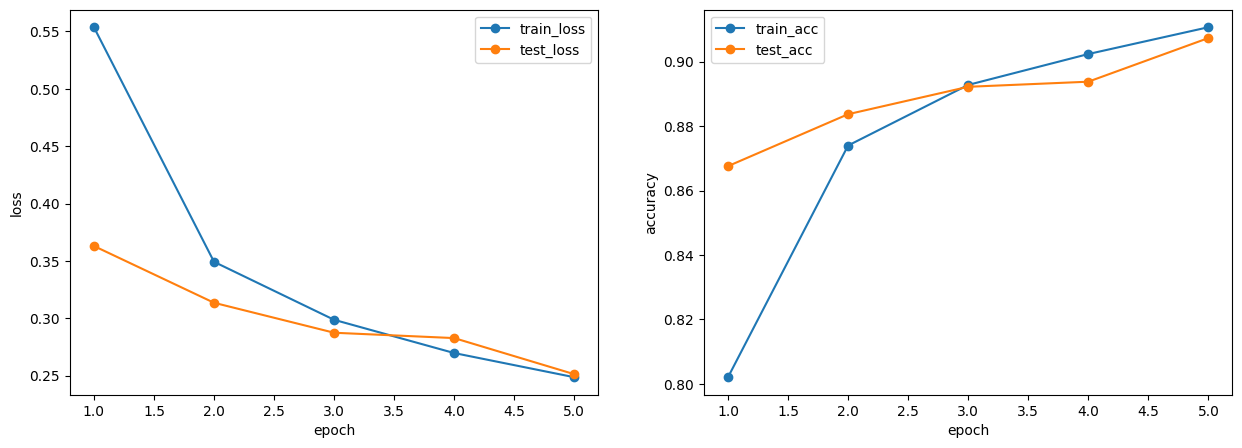

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), ## , label="train_loss", marker='o')
plt.plot(range(1, num_epochs+1), history["test_loss"], label= ## , marker='o')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), history["train_acc"], label="train_acc", marker='o')
plt.plot(range(1, num_epochs+1), ## , label="test_acc", marker='o')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

plt.##


## 4️⃣ **Evaluation**

### 4.1 Plot confusion matrix

A table showing counts of:

* true class (rows)
* predicted class (columns)

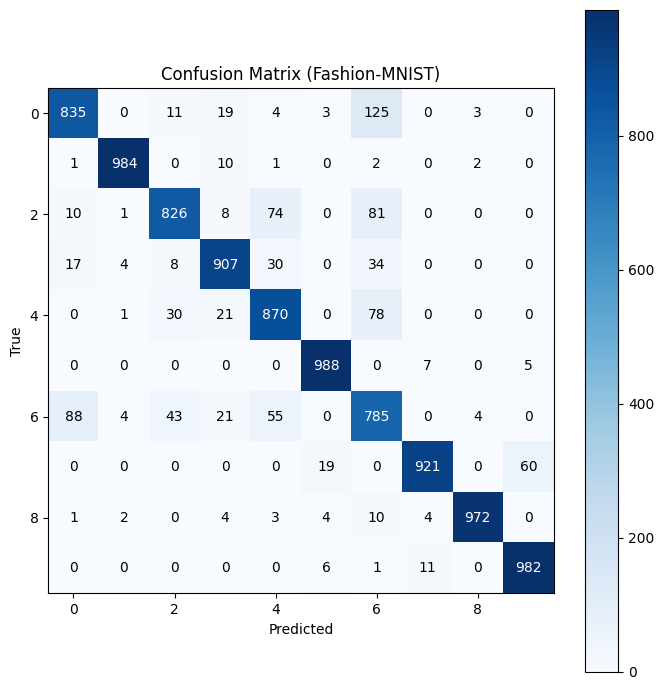

In [ ]:
def collect_preds(model, loader):
    """Collect all predictions and true labels for confusion matrix"""
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for batch in loader:
            images, labels = batch['image'], batch['label']
            images = images.to(device)

            # TO-DO: Get model predictions
            logits = ##(images)

            # TO-DO: Convert logits to predicted classes
            # HINT: Use argmax to get class indices
            preds = torch.argmax(##, dim=##)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_preds), np.array(all_labels)

# Collect predictions
preds, labels = collect_preds(model, test_loader)

# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


### 4.2 View ground truth and model prediction samples

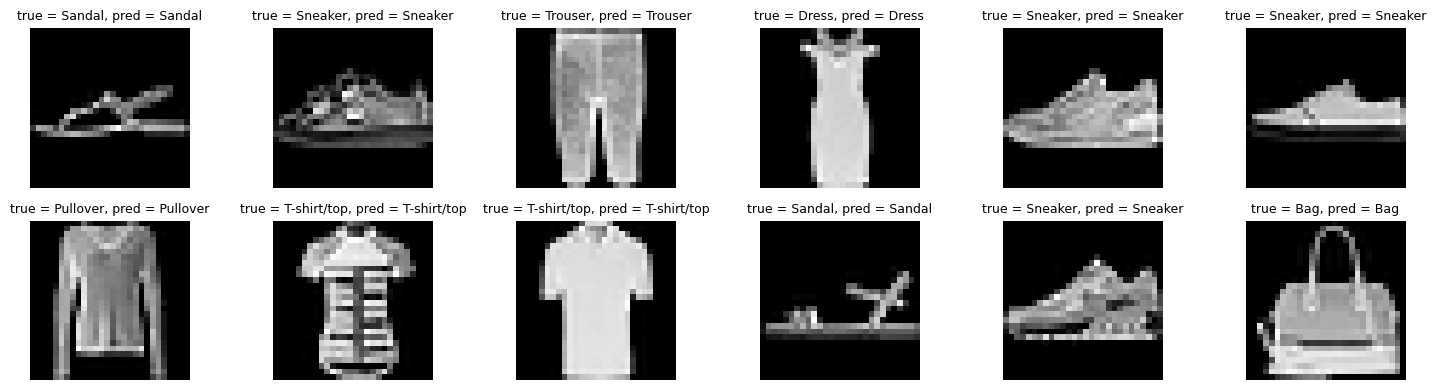

In [ ]:
@torch.no_grad()
def show_predictions(model, dataset, n=12):
    model.eval()
    fig, axes = plt.subplots(2, n//2, figsize=(15, 4))
    axes = axes.ravel()

    for i in range(n):
        sample = dataset[np.random.randint(0, len(dataset))]
        x, y = sample['image'], sample['label']
        logits = model(x.unsqueeze(0).to(device))
        pred = torch.argmax(logits, dim=1).item()

        x_vis = (x * 0.5) + 0.5
        axes[i].imshow(x_vis.squeeze(0), cmap="gray")
        axes[i].set_title(f"true = {class_names[y]}, pred = {class_names[pred]}", fontsize=9)
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

show_predictions(model, test_ds, n=12)


## 5️⃣ **Your turn**: optimize this pipeline through performing the following

- add `BatchNorm2d` after conv layers
- try a slightly deeper CNN (more channels)
- add `RandomRotation(10)` augmentation
- tune LR + epochs


![its ez](https://tenor.com/view/easy-staples-that-was-easy-staples-easy-button-easy-button-gif-21815485.gif)

### Contributed by: Farah Alshiha

![image.png](https://i.imgur.com/a3uAqnb.png)